In [38]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests
import cv2 
from numpy.polynomial import Polynomial
from skimage.morphology import skeletonize, binary_closing, square, binary_erosion, binary_dilation, medial_axis, thin, disk, convex_hull_image, diamond, star, isotropic_closing, remove_small_objects
from skimage.filters import threshold_otsu
import json
import time

In [39]:
sem_segm_img_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/main_7/picked_masks/2023_RVV_1_mask_1302.jpg"
mapbox_imgs_dir_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/main_7/mapbox_method_no_stitching/mapbox_images_for_frame_1302_RVV1"
heli_lat = 50.795680
heli_lon = 3.591033
altitude = 155.87

In [40]:
def plot_image(img):
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [41]:
def plot_patch(img, center_pixel, patch_size) : 
    # Calculate the patch boundaries
    top = center_pixel[0] - patch_size // 2
    bottom = top + patch_size
    left = center_pixel[1] - patch_size // 2
    right = left + patch_size

    # Ensure the patch boundaries stay within the image dimensions
    if top < 0:
        top = 0
    if bottom > img.shape[0]:
        bottom = img.shape[0]
    if left < 0:
        left = 0
    if right > img.shape[1]:
        right = img.shape[1]

    # Extract the patch from the image
    patch = img[top:bottom, left:right]

    # Plot the patch
    plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))  # Assuming the image is grayscale
    plt.axis('off')  # Hide axes
    plt.show()

In [42]:
def calculate_bearing(lat1, long1, lat2, long2) : 
    lat1 = math.radians(lat1)
    long1 = math.radians(long1)
    lat2 = math.radians(lat2)
    long2 = math.radians(long2)

    d_long = long2 - long1

    y = math.sin(d_long) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_long)

    brng = math.atan2(y, x)

    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    # brng = 360 - brng # count degrees clockwise - remove to make counter-clockwise
    return brng

In [43]:
def haversine(lat1, lon1, lat2, lon2) : 
    R = 6371
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    a = math.sin(d_lat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c * 1000
    return d

In [44]:
# calculate pitch/tilt
def calculate_pitch(heli_lat, heli_lon, intersec_lat, intersec_lon, alt) : 
    dist = haversine(heli_lat, heli_lon, intersec_lat, intersec_lon)

    # result = heli_df[(heli_df['lat'] == heli_lat) & (heli_df['lng'] == heli_lon)]
    # if not result.empty:
    #    altitude = result.iloc[0]['alt']

    print(f"Distance: {dist}")
    print(f"Altitude: {alt}")

    alpha_radian = math.atan2(alt, dist)
    alpha_degrees = alpha_radian * (180.0 / math.pi)
    pitch = 90 - alpha_degrees
    return pitch 

In [45]:
def get_mapbox_intersection_image(lat, lon, bearing, tilt) : 
    if tilt > 60 :
        tilt = 60
    zoom = 18
    width = 512
    height = 512
    access_token = "pk.eyJ1Ijoic2VubmVsb29idXljayIsImEiOiJjbG1zeDVreHowZmw5Mm1xY2lxeTFtYTB2In0.ymj-xZAfeeivbksi1PJttw" 
    styles_url = "mapbox://styles/senneloobuyck/cllcojw8d00wy01pb6rqcdmm5"

    style_code = styles_url.split('/')[-1]

    # Add a timestamp parameter to the URL to prevent caching
    timestamp = int(time.time())  # Current UNIX timestamp
    url = f"https://api.mapbox.com/styles/v1/senneloobuyck/{style_code}/static/{str(lon)},{str(lat)},{str(zoom)},{str(bearing)},{str(tilt)}/{str(width)}x{str(height)}?access_token={access_token}&fresh=true"
    response = requests.get(url)

    if response.status_code == 200:
        with open(f"{lat}-{lon}.jpg", "wb") as f:
            f.write(response.content)
        print(f"Image saved as {lat}_{lon}.jpg")
    else:
        print("Failed to retrieve image for intersection lat = " + str(lat) + ", lon = " + str(lon))
        print(response.text[:100])

In [46]:
def get_intersection_coordinates(lat, lon) : 
    # some lists and dataframes to store the data
    nodes = []
    intersection_nodes = []
    df_nodes = pd.DataFrame(columns=['id', 'lat', 'lon'])
    df_intersections = pd.DataFrame(columns=['lat', 'lon'])

    overpass_url = "http://overpass-api.de/api/interpreter"


    # first get the ways around the point 
    # .w is a temporary variable that stores the result of the first query
    # node(way_cnt:2-);   // select those nodes that are members of two or more of the given ways
    overpass_query = f"""[out:json];
                        way(around: 300, {lat},{lon})["highway"~"(motorway|trunk|primary|secondary|tertiary|unclassified|residential|motorway_link|trunk_link|primary_link|secondary_link|tertiary_link|living_street|service|pedestrian)"]->.w;
                        node(way_cnt.w:2-);  
                        out;"""

    response = requests.get(overpass_url, params={'data': overpass_query})

    # print(response.json()['elements'])

    for item in response.json()['elements']:
        df_intersections.loc[len(df_intersections)] = {'lat': item['lat'], 'lon': item['lon']}


    # print(df_intersections)
    return df_intersections

In [47]:
df_intersections = get_intersection_coordinates(heli_lat, heli_lon)

# read in csv file with heli coordinates
heli_path = "/Users/senneloobuyck/Documents/Thesis_project/01_inputs/csv-files/2023 Ronde van Vlaanderen 1 heli.csv"
heli_df = pd.read_csv(heli_path)
heli_df['lat'] = heli_df.apply(lambda row: float(row['lat']) * 1 if row['NS'] == 'N' else float(row['lat']) * (-1), axis=1)
heli_df['lng'] = heli_df.apply(lambda row: float(row['lng']) * 1 if row['EW'] == 'E' else float(row['lng']) * (-1), axis=1)
heli_df = heli_df[['lat', 'lng', 'alt', 'seconds_from_start']]

for index, row in df_intersections.iterrows() : 
    print(f"Intersection: {row['lat']},{row['lon']}")
    bearing = calculate_bearing(heli_lat, heli_lon, row['lat'], row['lon'])
    print(f"Bearing = {bearing}")
    pitch = calculate_pitch(heli_lat, heli_lon, row['lat'], row['lon'], alt=altitude)
    print(f"Pitch = {pitch}")
    # get_mapbox_intersection_image(row['lat'], row['lon'], bearing, pitch)

Intersection: 50.7961267,3.5930602
Bearing = 70.7799754168916
Distance: 150.8907280317825
Altitude: 155.87
Pitch = 44.070069303431275
Intersection: 50.7968232,3.5941811
Bearing = 60.120750856993936
Distance: 255.1775405919482
Altitude: 155.87
Pitch = 58.58217869849949
Intersection: 50.7969549,3.5946137
Bearing = 60.60622092041086
Distance: 288.8464962349801
Altitude: 155.87
Pitch = 61.64740562678031
Intersection: 50.7959163,3.5913055
Bearing = 36.08889878199403
Distance: 32.51486884822422
Altitude: 155.87
Pitch = 11.783067736716148
Intersection: 50.7958647,3.5910548
Bearing = 4.266621022996844
Distance: 20.594778622705622
Altitude: 155.87
Pitch = 7.52677386672417
Intersection: 50.7954316,3.5882332
Bearing = 262.01119622562294
Distance: 198.71330932663636
Altitude: 155.87
Pitch = 51.88949124124835
Intersection: 50.7975002,3.5913741
Bearing = 6.755022745542988
Distance: 203.81189248318736
Altitude: 155.87
Pitch = 52.59218716384649
Intersection: 50.7965324,3.5951496
Bearing = 71.860097895

In [48]:
def get_skeleton(mask_bgr, contour) : 
    print("Getting the skeleton")

    mask_gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)

    # draw contour in white on black background
    contour_mask_gray = np.zeros_like(mask_gray)
    cv2.drawContours(contour_mask_gray, [contour], -1, 255, -1)

    ret, contour_mask_thresh_gray = cv2.threshold(contour_mask_gray, 127, 255, cv2.THRESH_BINARY)
    contour_mask_thresh_bgr = cv2.cvtColor(contour_mask_thresh_gray, cv2.COLOR_GRAY2BGR)
    # plot_image(contour_mask_thresh_bgr)

    
    # To avoid the precision loss when converting the image to bool, 
    # you can also binarize the image using one of the available thresholding algorithms
    thresh_otsu = threshold_otsu(contour_mask_thresh_gray)
    contour_mask_thresh_gray = contour_mask_thresh_gray > thresh_otsu
    
    # skeletonize
    # skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)
    skeleton_gray = skeletonize(contour_mask_thresh_gray, method='lee').astype(np.uint8)

    # np.set_printoptions(threshold=np.inf)
    # print("Skeleton image values:")
    # print(skeleton_gray)


    # plt.figure(figsize=(20,10))
    # plt.imshow(skeleton_gray, cmap='gray', interpolation='nearest')
    # plt.show()

    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)

    return skeleton_bgr
            

In [49]:
def is_valid_intersection(neighbourhood_patch) : 
    # A list of valid intersections             
    # These are in the format (clockwise order)
    # 2 3 4
    # 1 C 5
    # 8 7 6 
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    
    if neighbourhood_patch in validIntersection : 
        return True
    else : 
        return False

In [50]:
def get_skeleton_intersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton"""
    print("Getting intersections in skeleton (more than 2 neighbours)")
    skeleton_gray = cv2.cvtColor(skeleton, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255
    intersections = []
    for y in range(1,len(image)-1):
        for x in range(1,len(image[y])-1):
            # if we have a white pixel
            if image[y][x] == 1:
                neighbourhood_patch = [image[y][x-1], image[y-1][x-1], image[y-1][x], image[y-1][x+1], image[y][x+1], image[y+1][x+1], image[y+1][x], image[y+1][x-1]]
                if is_valid_intersection(neighbourhood_patch):
                    intersections.append((y,x))
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    # for point1 in intersections:
    #     for point2 in intersections:
    #         if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
    #             intersections.remove(point2)
    # Remove duplicates
    return intersections


In [51]:
def get_neighbour_pixels(skel_contour_bgr, intersec) : 
    
    # print(f"Getting neighbour pixels for pixel {intersec}")
    
    skel_contour_bgr_copy = skel_contour_bgr.copy()
    
    # converting to grayscale gives false values
    # skel_contour_gray = cv2.cvtColor(skel_contour_bgr, cv2.COLOR_BGR2GRAY)

    # plot_patch(skel_contour_bgr_copy, intersec, 7)


    # Calculate neighbour pixels that define the roads that intersect (in patch values)
    road_neighbour_pixels = []
    for x in range(-1,2):
        for y in range(-1,2):
            pixel_color = skel_contour_bgr[intersec[0] + y, intersec[1] + x]
            # print(f"Pixel color = {pixel_color}")
            if np.all(pixel_color == np.array([255, 255, 255])) and (x != 0 or y != 0):
                road_neighbour_pixels.append((intersec[0]+y, intersec[1]+x))
                skel_contour_bgr_copy[intersec[0]+y, intersec[1]+x] = (0,0,255)
                # print(f"Neighbour pixel for pixel {intersec} within image: {intersec[0]+y}, {intersec[1]+x}")

    # plot_patch(skel_contour_bgr_copy, intersec, 7)

    return road_neighbour_pixels

In [52]:
def get_descriptors(skeleton_bgr, intersections, visualize=False) : 
    skeleton_gray = cv2.cvtColor(skeleton_bgr, cv2.COLOR_BGR2GRAY)

    dict_angles = {}
    dict_other_intersecs = {}
    descriptors = []

    skeleton_gray = cv2.cvtColor(skeleton_bgr, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255

    for intersection_pixel in intersections :
        dict_angles[intersection_pixel] = []
        dict_other_intersecs[intersection_pixel] = []
        # print(f"Getting neighbour pixels for intersection pixel {intersection_pixel}")
        neighbour_road_pixels = get_neighbour_pixels(skeleton_bgr, intersection_pixel)
        # print(f"Neighbour pixels: {neighbour_road_pixels}")

        for neighbour_pixel in neighbour_road_pixels :
            processed_pixels = [intersection_pixel] + neighbour_road_pixels
            road_pixels = []
            end_for_intersec_neighbour_pixel = False
            reference_pixel = neighbour_pixel
            count = 0
            count_treshold = 12
            skip_count_threshold = 2
            
            while count < count_treshold :
                # print(f"Getting new neighbour pixels for reference pixel {reference_pixel}")
                new_neighbour_pixels = get_neighbour_pixels(skeleton_bgr, reference_pixel)
                # print(f"New neighbour pixels: {new_neighbour_pixels}")


                new_neighbours_not_processed = [pixel for pixel in new_neighbour_pixels if pixel not in processed_pixels]
                if len(new_neighbours_not_processed) > 0 :
                    new_neighbour_pixel = new_neighbours_not_processed[0]
                    y, x = new_neighbour_pixel
                    new_neighbour_patch = [image[y][x-1], image[y-1][x-1], image[y-1][x], image[y-1][x+1], image[y][x+1], image[y+1][x+1], image[y+1][x], image[y+1][x-1]]
                    if is_valid_intersection(new_neighbour_patch) : 
                        # print(f"New neighbour pixel: {new_neighbour_pixel} is a valid intersection, end for this intersection pixel")
                        dict_other_intersecs[intersection_pixel].append(new_neighbour_pixel)
                        end_for_intersec_neighbour_pixel = True
                        break
                    else : 
                        processed_pixels.append(new_neighbour_pixel)
                        reference_pixel = new_neighbour_pixel

                    if count >= skip_count_threshold : 
                        if count == skip_count_threshold :
                            # print("Skip count threshold reached")
                            first_road_pixel = new_neighbour_pixel
                        if count == skip_count_threshold + 1 : 
                            second_road_pixel = new_neighbour_pixel
                        road_pixels.append(new_neighbour_pixel)
                else : 
                    # print("No new neighbour pixels found, end for this intersection pixel")
                    end_for_intersec_neighbour_pixel = True
                    break
                
                if end_for_intersec_neighbour_pixel is False :
                    count += 1
                else : 
                    break
            
            if count == count_treshold :
                # print("Count threshold reached")

                skeleton_bgr_copy = skeleton_bgr.copy()

                skeleton_bgr_copy[first_road_pixel[0], first_road_pixel[1]] = [0,0,255]
                skeleton_bgr_copy[second_road_pixel[0], second_road_pixel[1]] = [0,255,0]
                # all the other road pixels in blue 
                for pixel in road_pixels :
                    if pixel != first_road_pixel and pixel != second_road_pixel :
                        skeleton_bgr_copy[pixel[0], pixel[1]] = [255,0,0]

                
                plot_patch(skeleton_bgr_copy, first_road_pixel, 23)


                # print(f"Shape of skeleton_gray: {skeleton_gray.shape}")


                # Now use the first road pixel as origin and compute the angle of the road segment
                # First reverse the y coordinates to make sure the origin is in the bottom left corner
                road_pixels = [((skeleton_gray.shape[0]-1)-pixel[0], pixel[1]) for pixel in road_pixels]
                # print(f"Road pixels: {road_pixels}")

                first_road_pixel = ((skeleton_gray.shape[0]-1)-first_road_pixel[0], first_road_pixel[1])
                second_road_pixel = ((skeleton_gray.shape[0]-1)-second_road_pixel[0], second_road_pixel[1])

                # Adjust the coordinates of road pixels and intersection to be relative to the center
                adjusted_road_pixels = [(pixel[0] - first_road_pixel[0], pixel[1] - first_road_pixel[1]) for pixel in road_pixels]
                # print(f"Adjusted road pixels: {adjusted_road_pixels}")

                second_road_pixel = (second_road_pixel[0] - first_road_pixel[0], second_road_pixel[1] - first_road_pixel[1])
                first_road_pixel = (0,0)
                # print(f"First road pixel: {first_road_pixel}")
                # print(f"Second road pixel: {second_road_pixel}")

                # For each set of coordinates, compute the best-fit line
                x_values = np.array([coord[1] for coord in adjusted_road_pixels])
                y_values = np.array([coord[0] for coord in adjusted_road_pixels])

                positive_x_directions = 0
                negative_x_directions = 0
                positive_y_directions = 0
                negative_y_directions = 0
                for x in x_values:
                    if x > 0:
                        positive_x_directions += 1
                    elif x < 0:
                        negative_x_directions += 1
                
                for y in y_values:
                    if y > 0:
                        positive_y_directions += 1
                    elif y < 0:
                        negative_y_directions += 1

                # Check if all x-values are the same
                all_x_values_same = all(x == x_values[0] for x in x_values)
                if all_x_values_same :
                    print("All x-values are the same")
                    if second_road_pixel[0] > first_road_pixel[0] :
                        # index 0 because y coordinate needed (index 1 is x coordinate)
                        angle = 90
                    else :
                        angle = 270
                    print(f"Angle is: {angle}")
                    dict_angles[intersection_pixel].append(angle)
                    continue

                line = np.polyfit(x_values, y_values, deg=1)
                
                # print(f"Line: {line}")

                # Now show the line on the patch
                a = line[0]
                b = line[1]
                y = a * x_values + b
                if visualize : 
                    plt.plot(x_values, y)
                    plt.show()

                # The slope of each line gives the direction of the road segment it fits
                angle = np.degrees(np.arctan(a))
                # print(f"Angle: {angle}")

                if angle == 0 and negative_x_directions > positive_x_directions :
                    angle = 180

                if angle > 0 and negative_y_directions > positive_y_directions :
                    angle = angle + 180
                
                if angle < 0 :
                    if negative_y_directions < positive_y_directions :
                        angle = angle + 180
                    else : 
                        angle = angle + 360

                print(f"Angle is: {angle}")
                dict_angles[intersection_pixel].append(angle)
            else : 
                print("Count threshold not reached")
    

    processed_intersections = []
    for intersection in dict_other_intersecs.keys() : 
        if intersection in processed_intersections :
            continue
        # print(f"dict_other_intersecs[intersection]: ")
        # print(dict_other_intersecs[intersection])
        if len(dict_other_intersecs[intersection]) == 0 :
            descriptor = dict_angles[intersection]
            sorted_descriptor = sorted(descriptor)
            descriptors.append(sorted_descriptor)
            processed_intersections.append(intersection)
        else :
            for other_intersection in dict_other_intersecs[intersection] : 
                if other_intersection not in processed_intersections : 
                    descriptor = dict_angles[intersection] + dict_angles[other_intersection]
                    sorted_descriptor = sorted(descriptor)
                    descriptors.append(sorted_descriptor)
                    processed_intersections.append(intersection)
                    processed_intersections.append(other_intersection)
                else: 
                    continue
    
    return descriptors


In [53]:
def find_descriptors_in_segmentation_image(img_path) : 
    print("Finding descriptors in segmentation image")
    
    img_bgr = cv2.imread(img_path)
    print("Segmentation image")
    plot_image(img_bgr)

    closing_bgr = isotropic_closing(img_bgr, radius=30)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    print("Isotropic closing of segmentation image")
    plot_image(closing_bgr)

    closing_bgr_copy = closing_bgr.copy()
    mask_bgr_copy = closing_bgr.copy()
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(closing_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours: {len(contours)}")
    cv2.drawContours(closing_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            print(f"Convex hull area: {convex_hull_area}")
            # cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            solidity = contour_area / convex_hull_area

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(mask_bgr_copy, contour)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)
            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")

                # further processing
                if skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    print(f"Intersections = {skel_intersections}")
                    
                    # visualization
                    skeleton_contour_bgr_copy = skeleton_contour_bgr.copy()
                    for intersection in skel_intersections :
                        skeleton_contour_bgr_copy[intersection[0], intersection[1]] = [0, 0, 255]
                    plot_image(skeleton_contour_bgr_copy)

                    # now try and match intersection with the openstreetmap images
                    descriptors = get_descriptors(skeleton_contour_bgr, skel_intersections)
                    
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors
    

Finding descriptors in segmentation image
Segmentation image


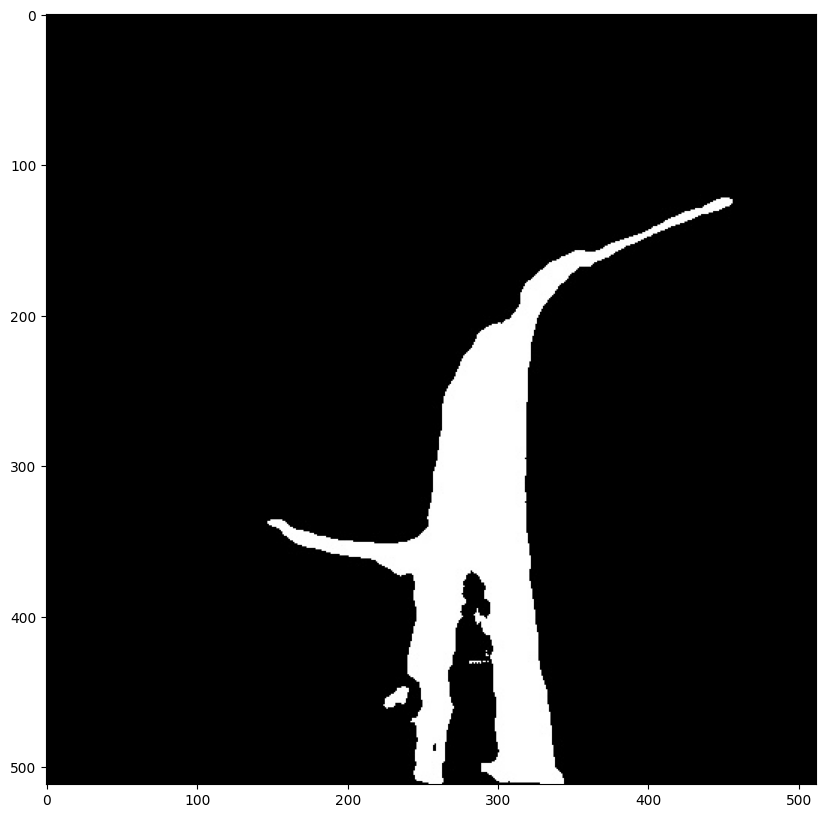

Isotropic closing of segmentation image


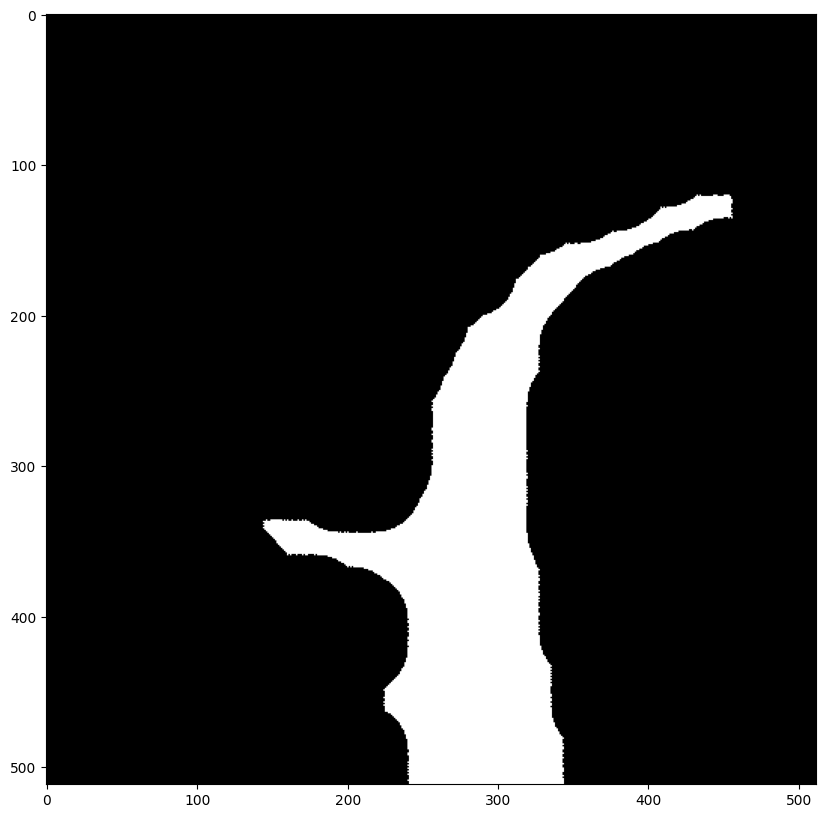

Number of contours: 1
Contour length: 1410.746379852295
Contour area: 30085.5
Convex hull area: 66685.5
Getting the skeleton
Getting intersections in skeleton (more than 2 neighbours)
Solidity = 0.4511550486987426 -> this contour can be related to an intersection in the road
Intersections = [(373, 279)]


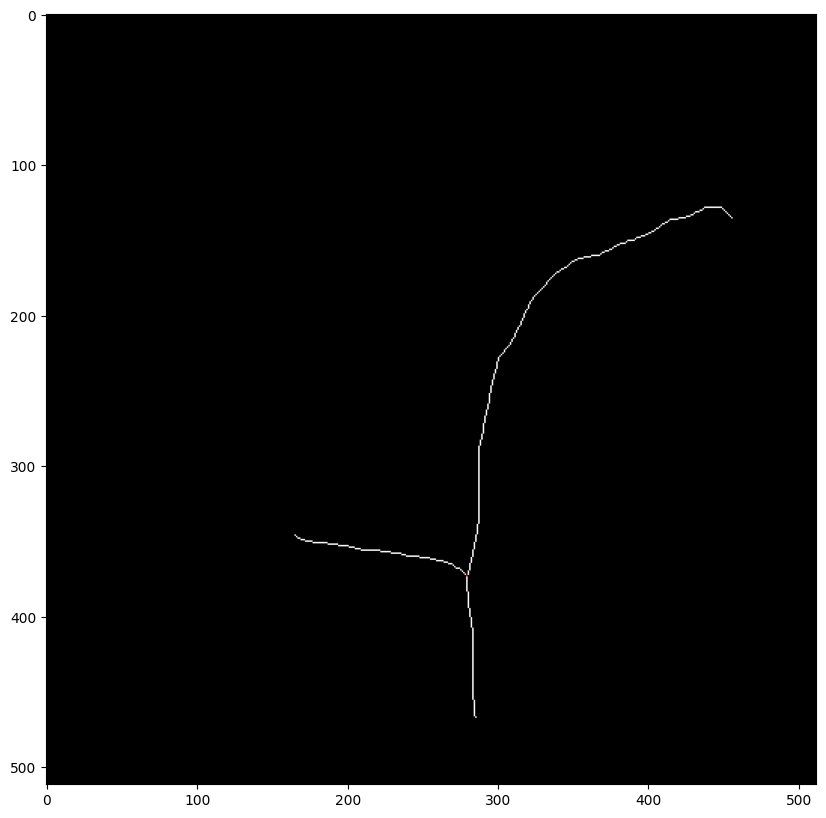

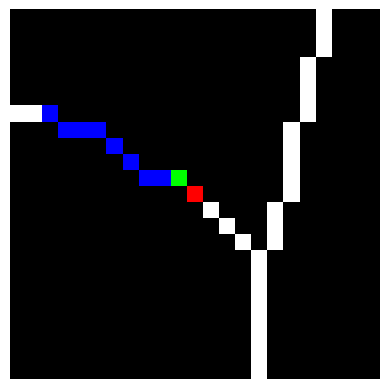

Angle is: 151.12259877771717


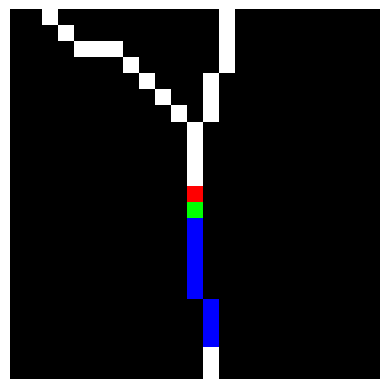

Angle is: 281.30993247402023


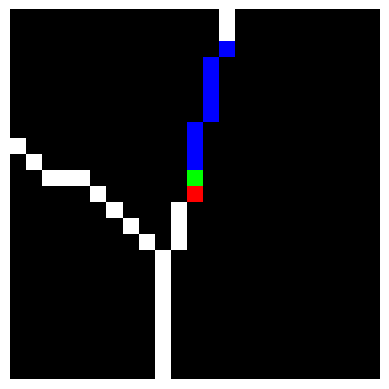

Angle is: 75.48894049983095
Array of descriptors: [[75.48894049983095, 151.12259877771717, 281.30993247402023]]


In [54]:
# segm_img_des = find_descriptors_in_segmentation_image(sem_segm_img_path)
segm_img_des = find_descriptors_in_segmentation_image(sem_segm_img_path) # without pruning
print(f"Array of descriptors: {segm_img_des}")

In [55]:
def find_descriptors_in_mapbox_image(img_path, image_name, vis=False) : 
    img_bgr = cv2.imread(img_path)
    # print("Mapbox image")
    # plot_image(img_bgr)

    new_width, new_height = img_bgr.shape[1], img_bgr.shape[0] - 100 
    cropped_img_bgr = img_bgr[0:new_height, 0:new_width]
    print("Cropped mapbox image")
    if vis : 
        plot_image(cropped_img_bgr)

    print("Binary thresholding")
    img_gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)
    ret, thresh_gray = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    thresh_bgr = cv2.cvtColor(thresh_gray, cv2.COLOR_GRAY2BGR)
    if vis :
        plot_image(thresh_bgr)

    closing_bgr = isotropic_closing(thresh_bgr, radius=3)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)
    print("Isotropic closing of segmentation image")
    if vis : 
        plot_image(closing_bgr)

    # To avoid the precision loss when converting the image to bool, 
    # you can also binarize the image using one of the available thresholding algorithms
    thresh_otsu = threshold_otsu(closing_gray)
    mask_gray = closing_gray > thresh_otsu
    
    # Skeletonize
    # skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)
    skeleton_gray = skeletonize(mask_gray, method='lee').astype(np.uint8)

    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)
    
    # find the intersections in the skeleton
    skel_intersections = get_skeleton_intersection(skeleton_bgr)

    print(f"{len(skel_intersections)} intersections found in the skeleton:")
    print(skel_intersections)

    descriptors = []
            
    #  if there are intersections
    if skel_intersections != [] :
        # visualization
        skeleton_bgr_copy = skeleton_bgr.copy()
        for intersection in skel_intersections :
            skeleton_bgr_copy[intersection[0], intersection[1]] = [0, 0, 255]

        if vis : 
            plot_image(skeleton_bgr_copy)


        print(f"There are intersections in mapbox image {image_name}")
        descriptors = get_descriptors(skeleton_bgr, skel_intersections, visualize = vis)   
    else :
        print("No intersections found in the skeleton")
        
    if descriptors == [] :
        return None
    else :
        return descriptors

**************************************************
Mapbox image: 50.7958647-3.5910548.jpg
**************************************************
Cropped mapbox image
Binary thresholding
Isotropic closing of segmentation image
Getting intersections in skeleton (more than 2 neighbours)
4 intersections found in the skeleton:
[(212, 346), (227, 344), (247, 257), (262, 254)]
There are intersections in mapbox image 50.7958647-3.5910548.jpg


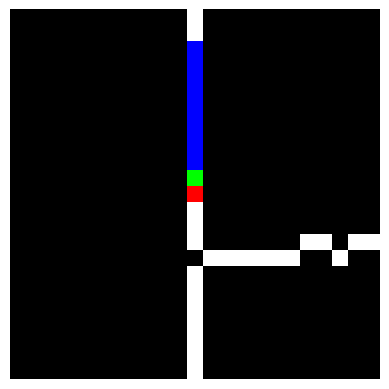

All x-values are the same
Angle is: 90


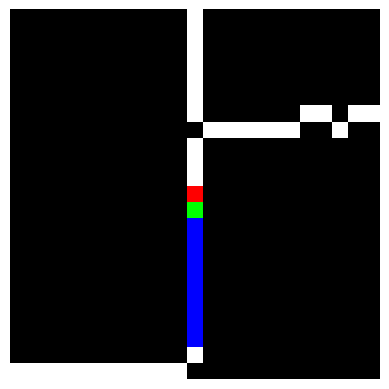

All x-values are the same
Angle is: 270


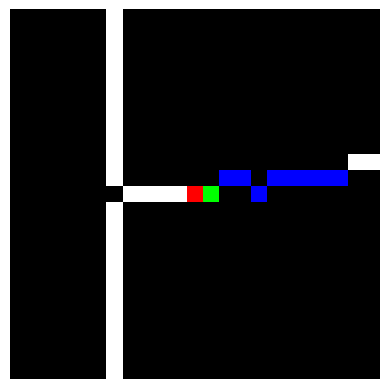

Angle is: 5.882445590095342


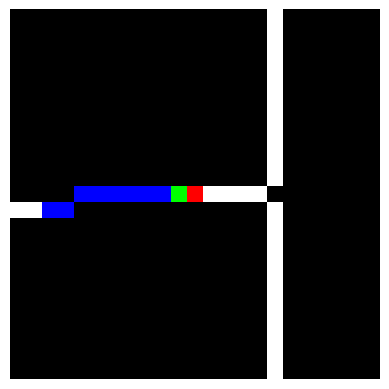

Angle is: 185.53863753279052


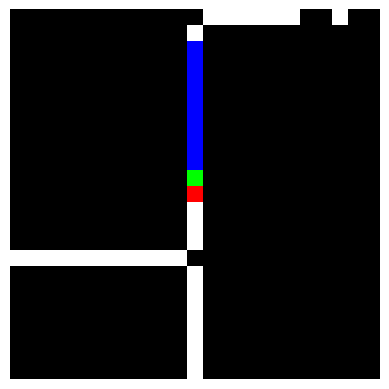

All x-values are the same
Angle is: 90


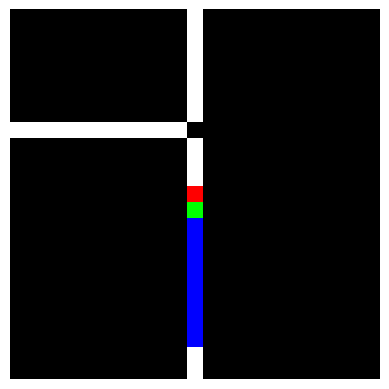

All x-values are the same
Angle is: 270


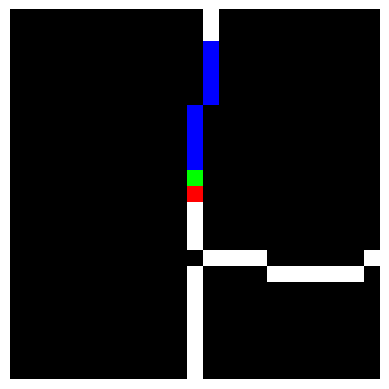

Angle is: 78.69006752597979


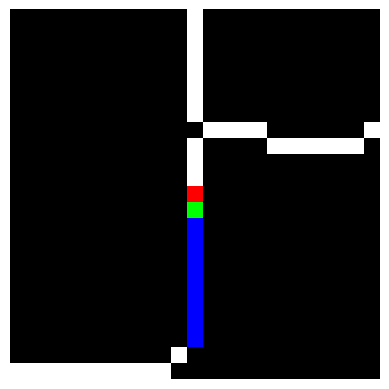

All x-values are the same
Angle is: 270


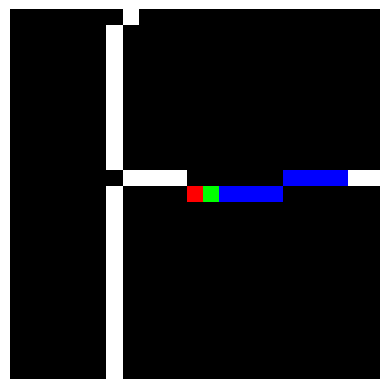

Angle is: 8.275892827075198


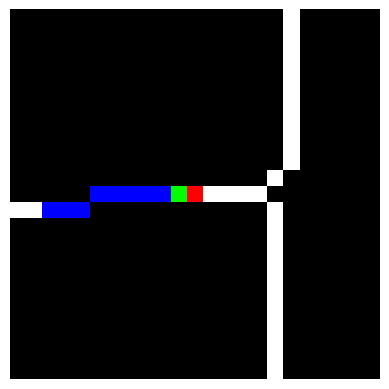

Angle is: 187.25319461272534


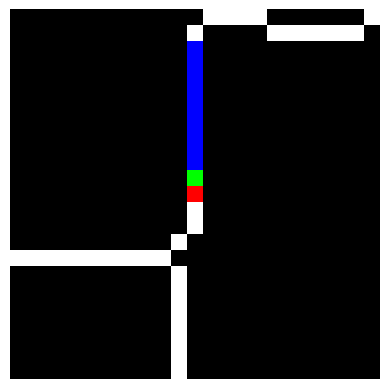

All x-values are the same
Angle is: 90


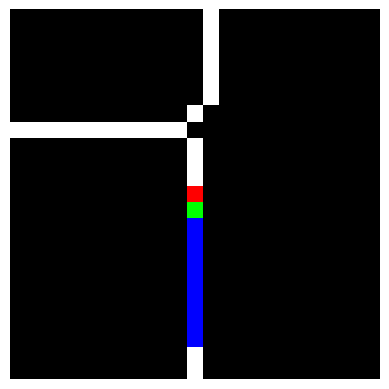

All x-values are the same
Angle is: 270
Descriptors for mapbox image 50.7958647-3.5910548.jpg:
[[5.882445590095342, 90, 270], [90, 185.53863753279052, 270], [8.275892827075198, 78.69006752597979, 270], [90, 187.25319461272534, 270]]
Number of descriptors: 4
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[5.882445590095342, 90, 270]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 5.882445590095342
Angle of mapbox image: 90
Angle of mapbox image: 270
Best diff = 14.511059500169054 with angle 90
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 5.882445590095342
Angle of mapbox image: 90
Angle of mapbox image: 270
Best diff = 118.87740122228283 with angle 270
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 5.882445590095342
Angle of mapbox image: 90
Angle of mapbox image: 270
Best diff = 84.57251311607513 with angle 5.882445590095342
Result = 146.611

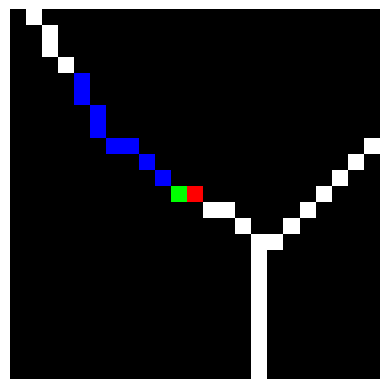

Angle is: 137.0863553097907


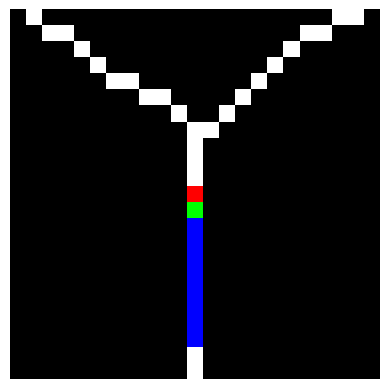

All x-values are the same
Angle is: 270


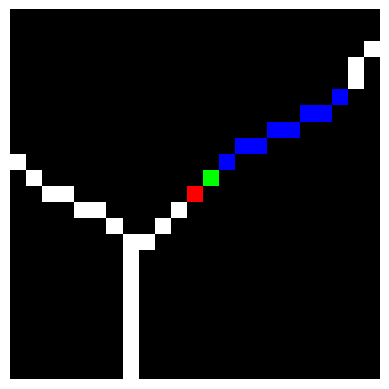

Angle is: 31.471684533627307


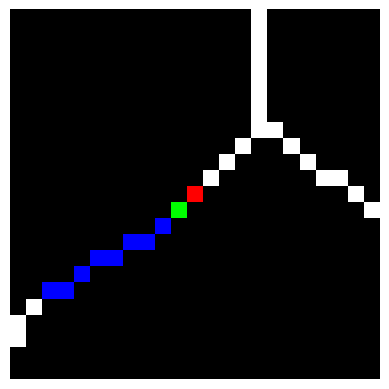

Angle is: 213.20657031508955


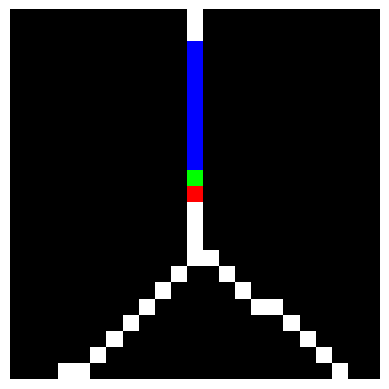

All x-values are the same
Angle is: 90


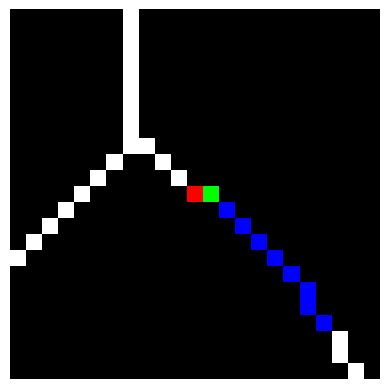

Angle is: 314.130065864371


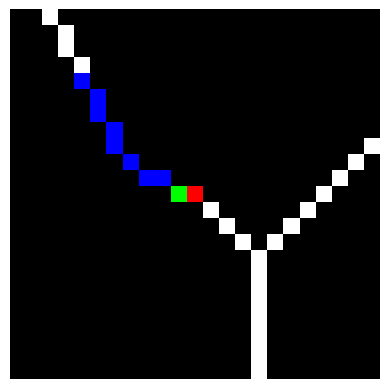

Angle is: 134.42010300507155


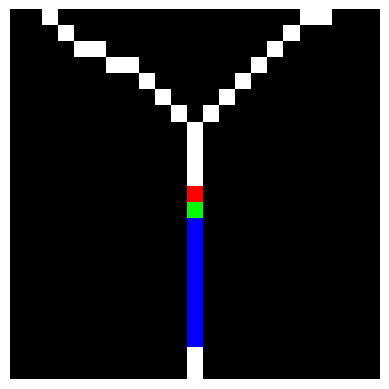

All x-values are the same
Angle is: 270


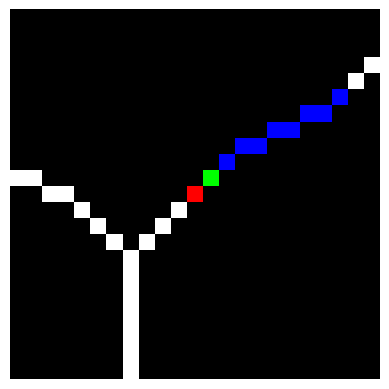

Angle is: 31.471684533627307


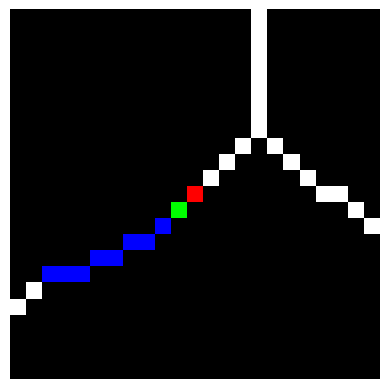

Angle is: 209.14297798197177


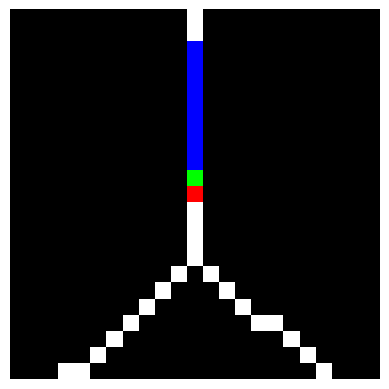

All x-values are the same
Angle is: 90


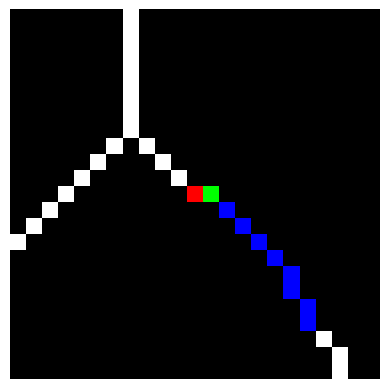

Angle is: 311.9072254199365
Descriptors for mapbox image 50.7959163-3.5913055.jpg:
[[31.471684533627307, 137.0863553097907, 270], [90, 213.20657031508955, 314.130065864371], [31.471684533627307, 134.42010300507155, 270], [90, 209.14297798197177, 311.9072254199365]]
Number of descriptors: 4
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[31.471684533627307, 137.0863553097907, 270]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 31.471684533627307
Angle of mapbox image: 137.0863553097907
Angle of mapbox image: 270
Best diff = 44.017255966203635 with angle 31.471684533627307
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 31.471684533627307
Angle of mapbox image: 137.0863553097907
Angle of mapbox image: 270
Best diff = 14.036243467926482 with angle 137.0863553097907
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 31.471684533627307
Angle of mapbox 

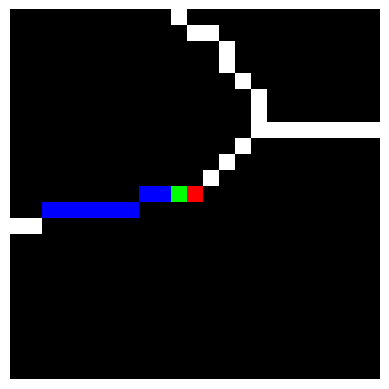

Angle is: 188.2758928270752


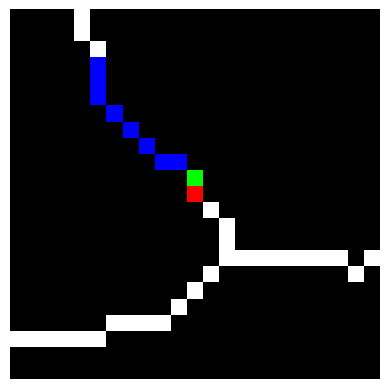

Angle is: 133.70627728358704


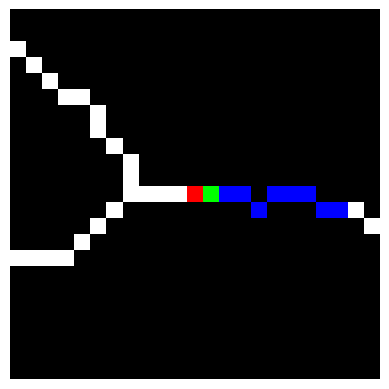

Angle is: 354.8055710922652


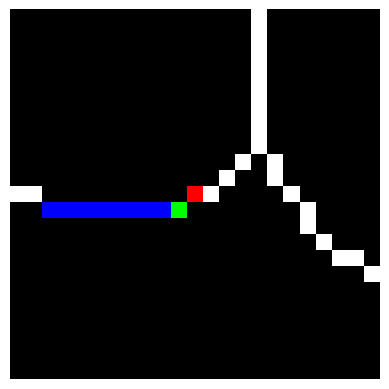

Angle is: 183.1221304621157


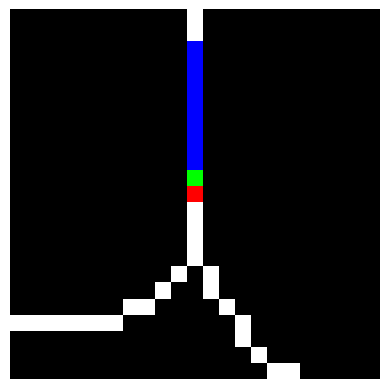

All x-values are the same
Angle is: 90


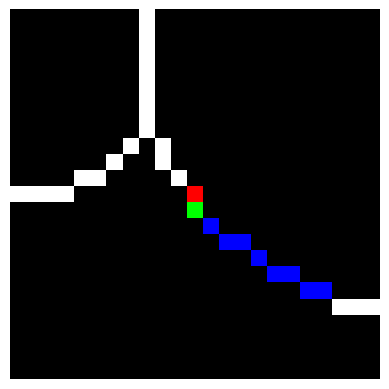

Angle is: 325.0493485881249


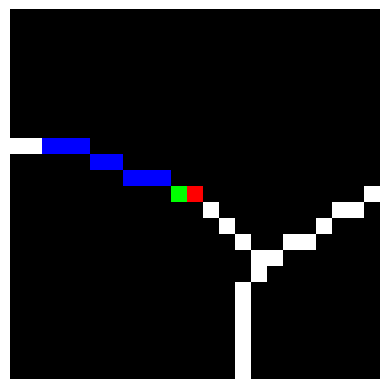

Angle is: 159.40590977969123


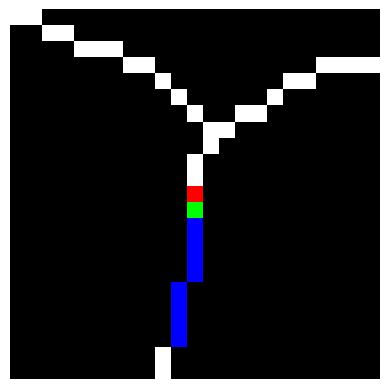

Angle is: 258.69006752597977


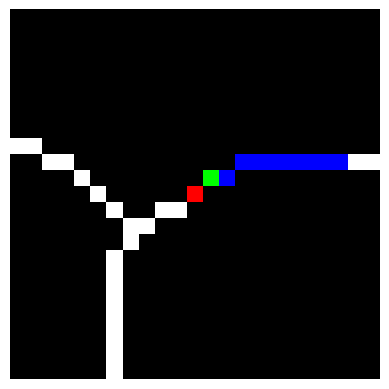

Angle is: 10.304846468766035
Descriptors for mapbox image 50.7976443-3.5937476.jpg:
[[133.70627728358704, 188.2758928270752, 354.8055710922652], [90, 183.1221304621157, 325.0493485881249], [10.304846468766035, 159.40590977969123, 258.69006752597977]]
Number of descriptors: 3
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[133.70627728358704, 188.2758928270752, 354.8055710922652]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 133.70627728358704
Angle of mapbox image: 188.2758928270752
Angle of mapbox image: 354.8055710922652
Best diff = 58.217336783756096 with angle 133.70627728358704
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 133.70627728358704
Angle of mapbox image: 188.2758928270752
Angle of mapbox image: 354.8055710922652
Best diff = 37.15329404935804 with angle 188.2758928270752
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 133.70627

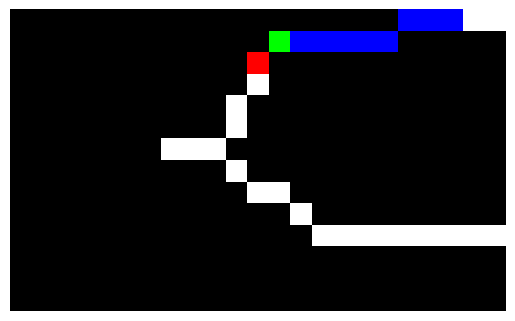

Angle is: 10.304846468766035


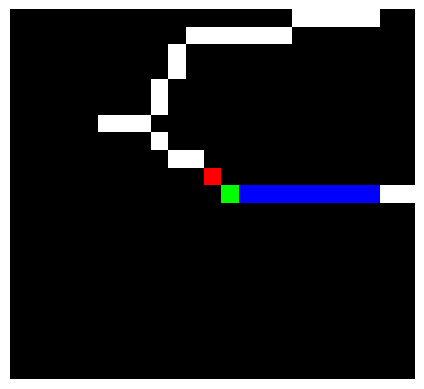

Angle is: 356.8778695378843
Count threshold not reached
Count threshold not reached


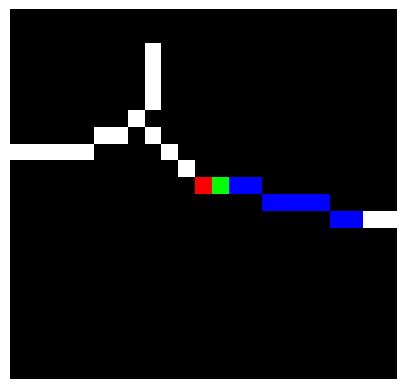

Angle is: 346.3730051401085


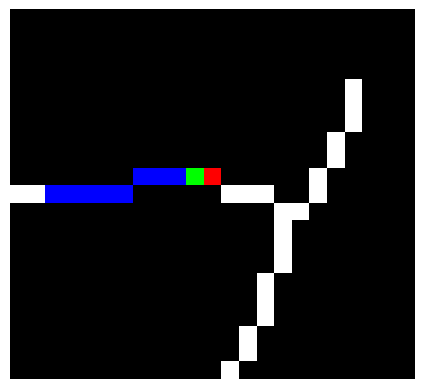

Angle is: 188.61564818416412


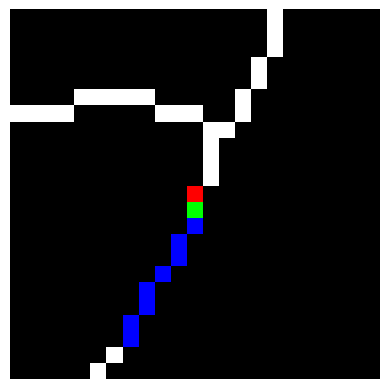

Angle is: 241.2403814662775
Count threshold not reached


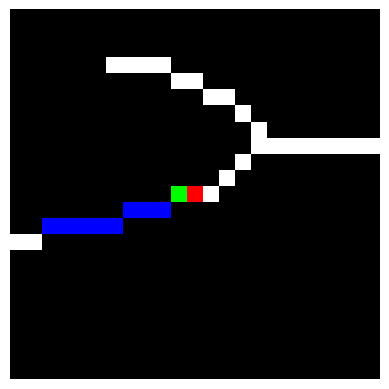

Angle is: 193.95450917313684
Count threshold not reached


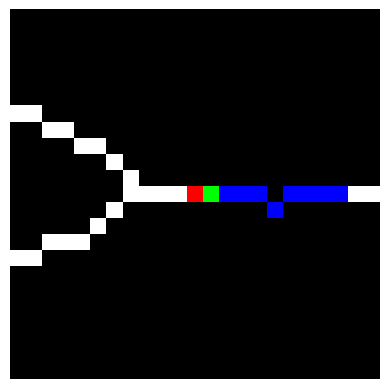

Angle is: 359.6527571029142


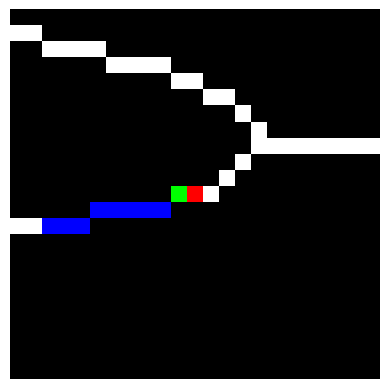

Angle is: 192.6390624406301


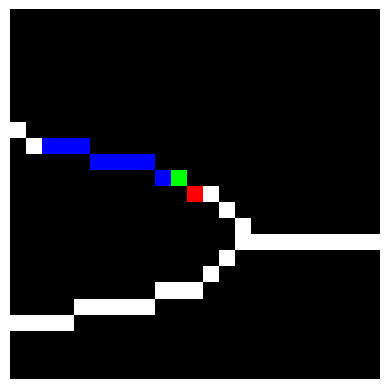

Angle is: 162.82409638425327


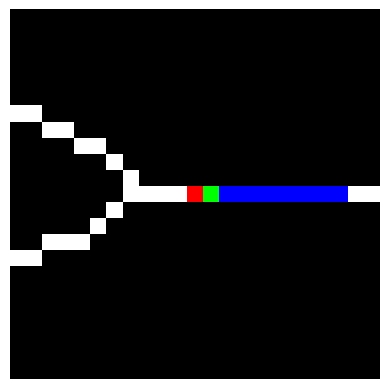

Angle is: 0.0


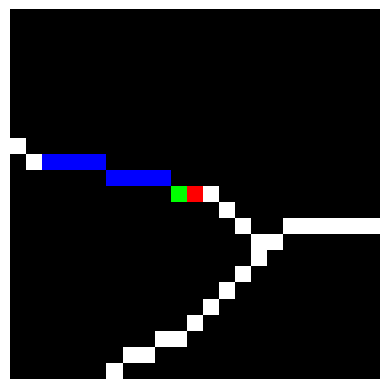

Angle is: 166.37300514010846


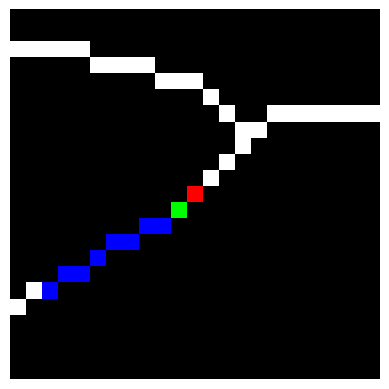

Angle is: 211.97415935312918


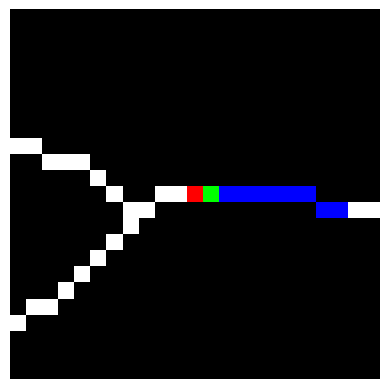

Angle is: 354.4613624672095


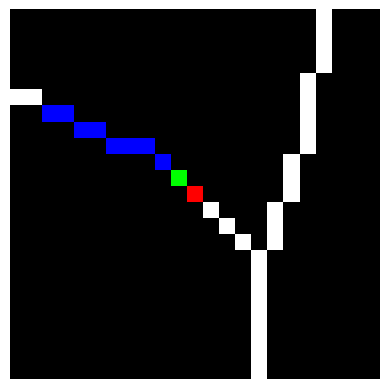

Angle is: 152.47092812754337


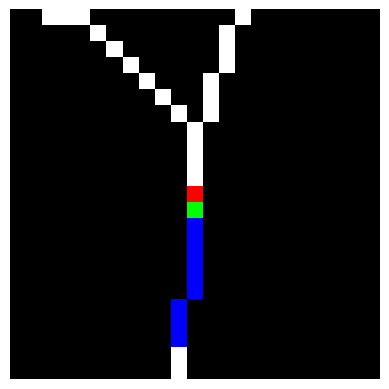

Angle is: 258.69006752597977


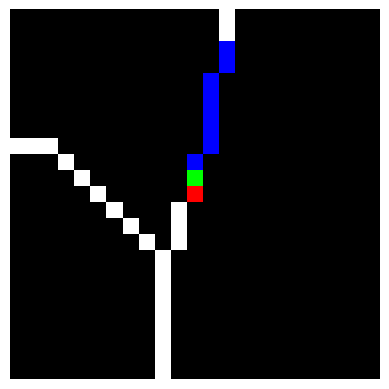

Angle is: 75.16500780574127


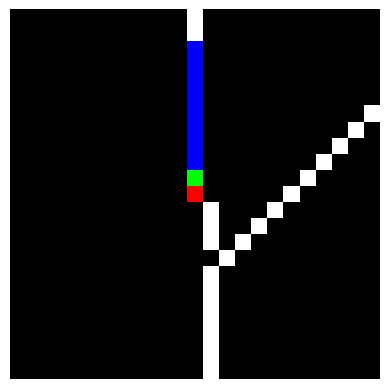

All x-values are the same
Angle is: 90


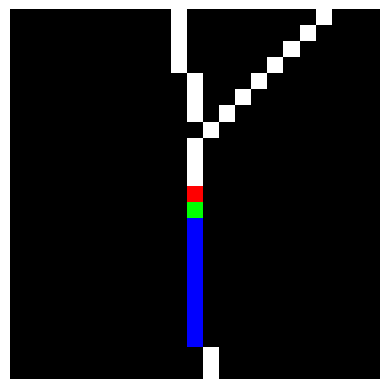

All x-values are the same
Angle is: 270


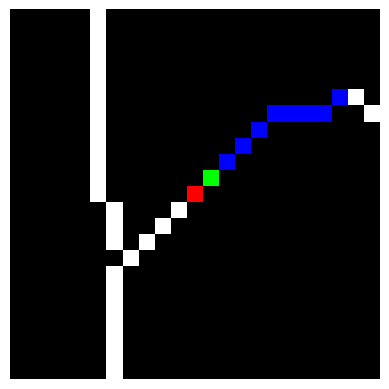

Angle is: 32.223355230747885
Descriptors for mapbox image 50.798307-3.5917455.jpg:
[[10.304846468766035, 356.8778695378843], [346.3730051401085], [188.61564818416412, 241.2403814662775], [193.95450917313684, 359.6527571029142], [0.0, 162.82409638425327, 192.6390624406301], [166.37300514010846, 211.97415935312918, 354.4613624672095], [75.16500780574127, 152.47092812754337, 258.69006752597977], [32.223355230747885, 90, 270]]
Number of descriptors: 8
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[10.304846468766035, 356.8778695378843]
Descriptor of mapbox image:
[346.3730051401085]
Descriptor of mapbox image:
[188.61564818416412, 241.2403814662775]
Descriptor of mapbox image:
[193.95450917313684, 359.6527571029142]
Descriptor of mapbox image:
[0.0, 162.82409638425327, 192.6390624406301]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 0.0
Angle of mapbox image: 162.82409638425327
Angle of mapb

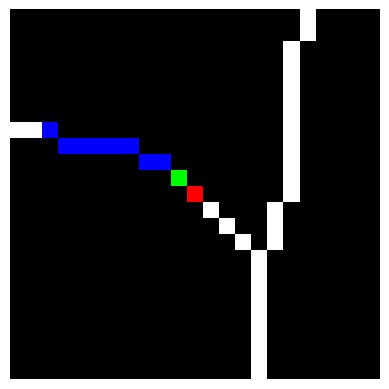

Angle is: 160.63265245222377


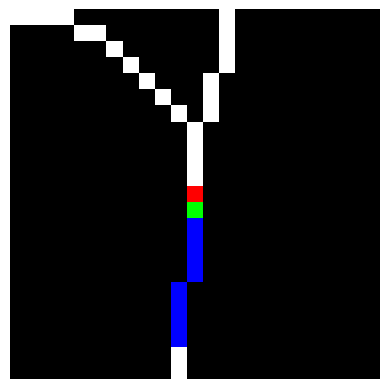

Angle is: 258.69006752597977


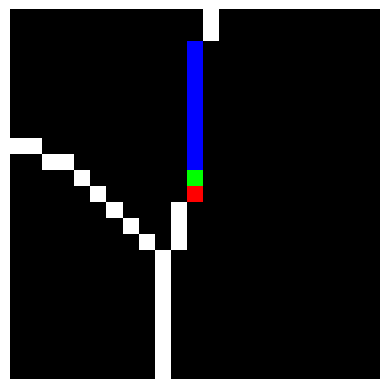

All x-values are the same
Angle is: 90


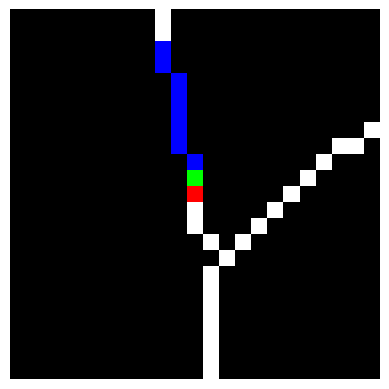

Angle is: 104.83499219425873


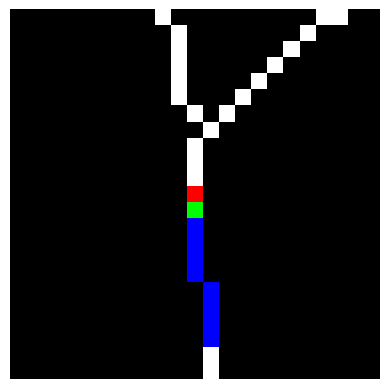

Angle is: 281.30993247402023


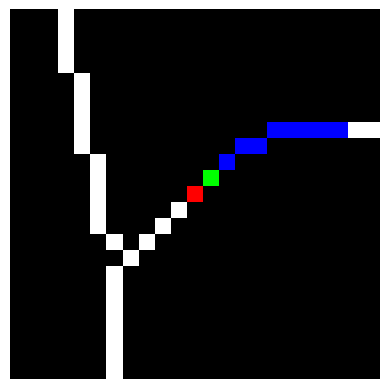

Angle is: 23.282356213489738
Descriptors for mapbox image 50.7978828-3.5914551.jpg:
[[90, 160.63265245222377, 258.69006752597977], [23.282356213489738, 104.83499219425873, 281.30993247402023]]
Number of descriptors: 2
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[90, 160.63265245222377, 258.69006752597977]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 90
Angle of mapbox image: 160.63265245222377
Angle of mapbox image: 258.69006752597977
Best diff = 14.511059500169054 with angle 90
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 90
Angle of mapbox image: 160.63265245222377
Angle of mapbox image: 258.69006752597977
Best diff = 9.510053674506594 with angle 160.63265245222377
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 90
Angle of mapbox image: 160.63265245222377
Angle of mapbox image: 258.69006752597977
Best diff = 22.61986494804046 with an

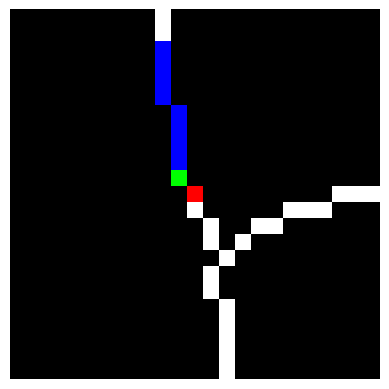

Angle is: 103.95450917313684


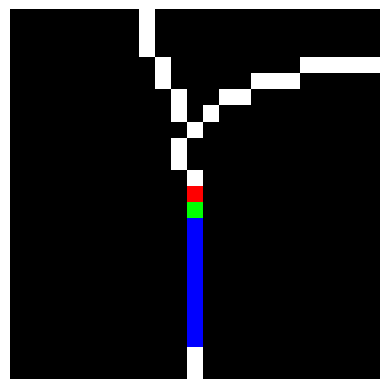

All x-values are the same
Angle is: 270


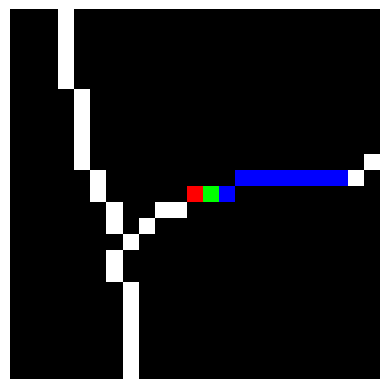

Angle is: 7.253194612725335
Descriptors for mapbox image 50.7954316-3.5882332.jpg:
[[7.253194612725335, 103.95450917313684, 270]]
Number of descriptors: 1
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[7.253194612725335, 103.95450917313684, 270]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 7.253194612725335
Angle of mapbox image: 103.95450917313684
Angle of mapbox image: 270
Best diff = 28.465568673305896 with angle 103.95450917313684
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 7.253194612725335
Angle of mapbox image: 103.95450917313684
Angle of mapbox image: 270
Best diff = 118.87740122228283 with angle 270
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 7.253194612725335
Angle of mapbox image: 103.95450917313684
Angle of mapbox image: 270
Best diff = 85.94326213870511 with angle 7.253194612725335
Result = 149.42680291132675
Score = 12.

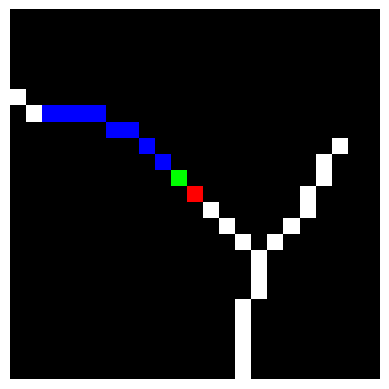

Angle is: 150.3299661843394


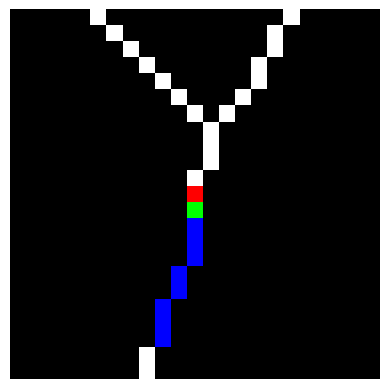

Angle is: 251.7146481726805
Count threshold not reached
Descriptors for mapbox image 50.79529-3.5912241.jpg:
[[150.3299661843394, 251.7146481726805]]
Number of descriptors: 1
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[150.3299661843394, 251.7146481726805]
Score = 31.622776601683793
**************************************************
Mapbox image: 50.7967252-3.5912128.jpg
**************************************************
Cropped mapbox image
Binary thresholding
Isotropic closing of segmentation image
Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton:
[]
No intersections found in the skeleton
Descriptors for mapbox image 50.7967252-3.5912128.jpg:
None
**************************************************
Mapbox image: 50.7947793-3.5911626.jpg
**************************************************
Cropped mapbox image
Binary thresholding
Isotropic closing of segmentation

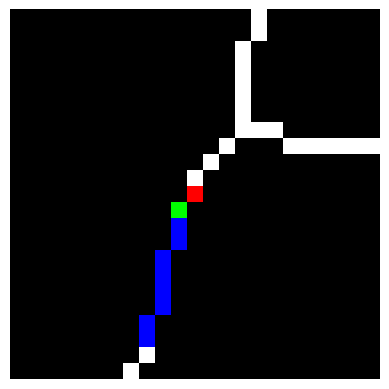

Angle is: 251.70548172801531


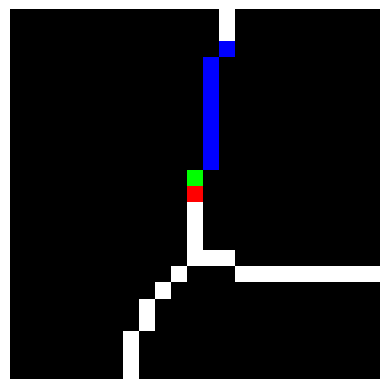

Angle is: 76.93844891667189


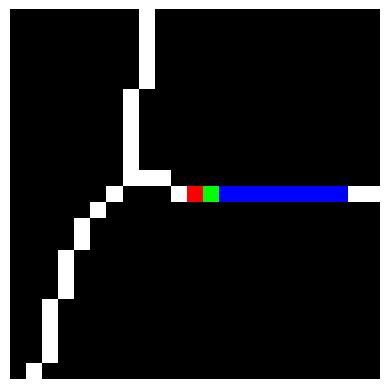

Angle is: 0.0


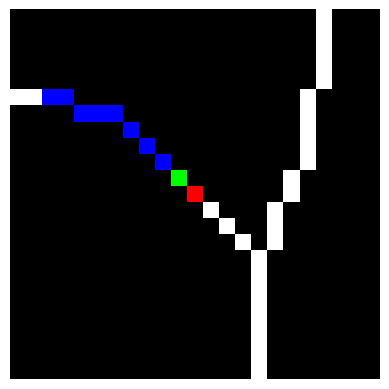

Angle is: 146.07020257793937


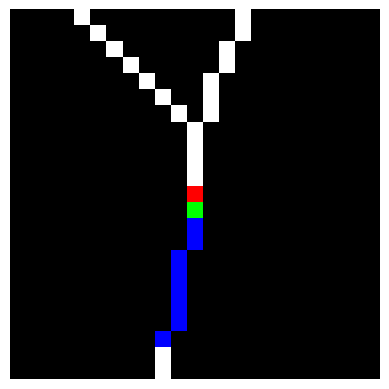

Angle is: 256.04549082686316


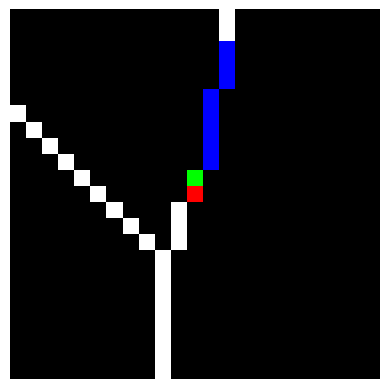

Angle is: 75.16500780574127
Descriptors for mapbox image 50.7947793-3.5911626.jpg:
[[0.0, 76.93844891667189, 251.70548172801531], [75.16500780574127, 146.07020257793937, 256.04549082686316]]
Number of descriptors: 2
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[0.0, 76.93844891667189, 251.70548172801531]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 0.0
Angle of mapbox image: 76.93844891667189
Angle of mapbox image: 251.70548172801531
Best diff = 1.449508416840942 with angle 76.93844891667189
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 0.0
Angle of mapbox image: 76.93844891667189
Angle of mapbox image: 251.70548172801531
Best diff = 100.58288295029814 with angle 251.70548172801531
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 0.0
Angle of mapbox image: 76.93844891667189
Angle of mapbox image: 251.70548172801531
Best diff = 78.690067525

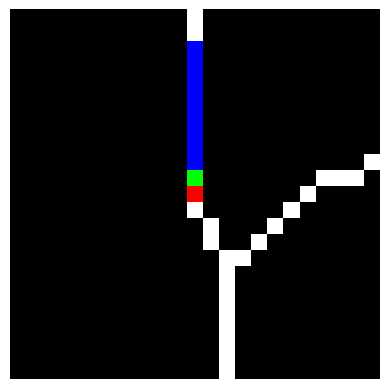

All x-values are the same
Angle is: 90


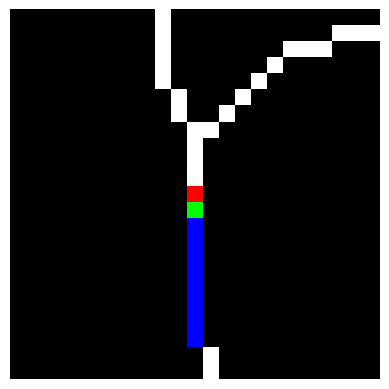

All x-values are the same
Angle is: 270


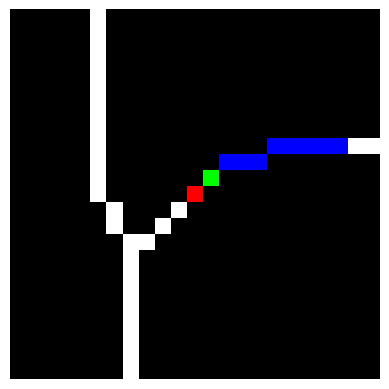

Angle is: 16.858398767738286


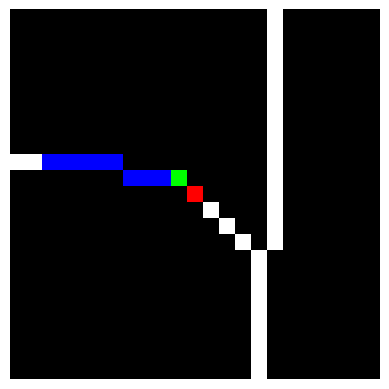

Angle is: 168.3565685012383


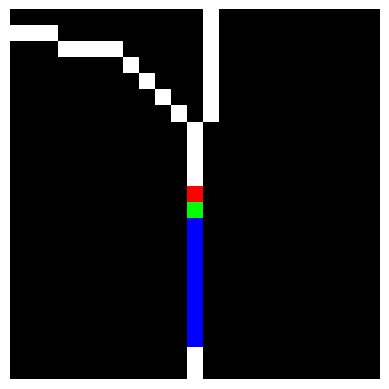

All x-values are the same
Angle is: 270


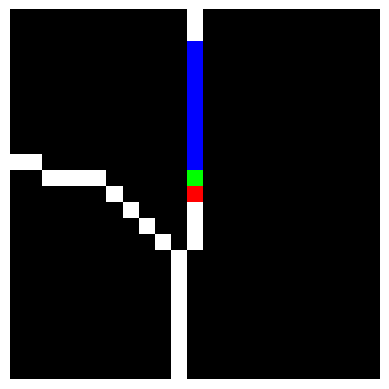

All x-values are the same
Angle is: 90
Descriptors for mapbox image 50.7975002-3.5913741.jpg:
[[16.858398767738286, 90, 270], [90, 168.3565685012383, 270]]
Number of descriptors: 2
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[16.858398767738286, 90, 270]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 16.858398767738286
Angle of mapbox image: 90
Angle of mapbox image: 270
Best diff = 14.511059500169054 with angle 90
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 16.858398767738286
Angle of mapbox image: 90
Angle of mapbox image: 270
Best diff = 118.87740122228283 with angle 270
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 16.858398767738286
Angle of mapbox image: 90
Angle of mapbox image: 270
Best diff = 95.54846629371804 with angle 16.858398767738286
Result = 153.20547242270047
Descriptor of mapbox image:
[90, 168.3565685012383, 270]
Ang

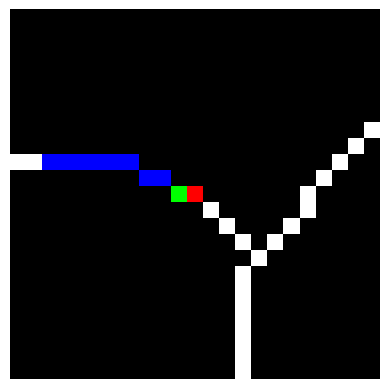

Angle is: 166.37300514010846


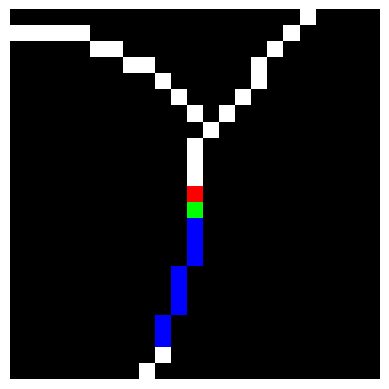

Angle is: 253.42904883308614


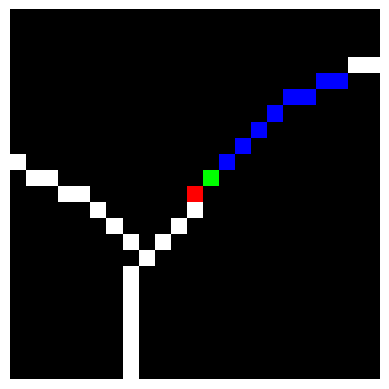

Angle is: 39.28940686250036


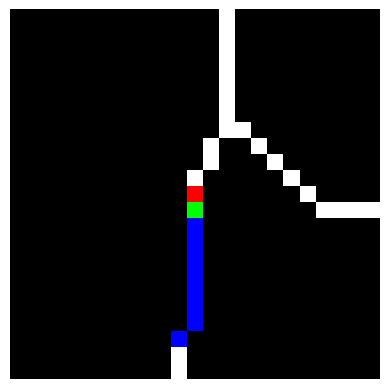

Angle is: 258.69006752597977


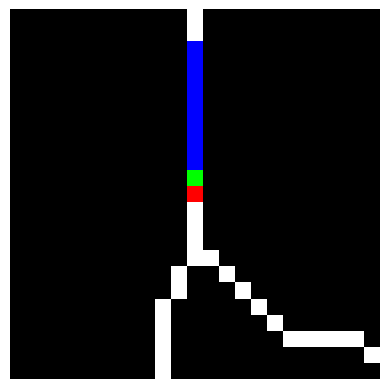

All x-values are the same
Angle is: 90


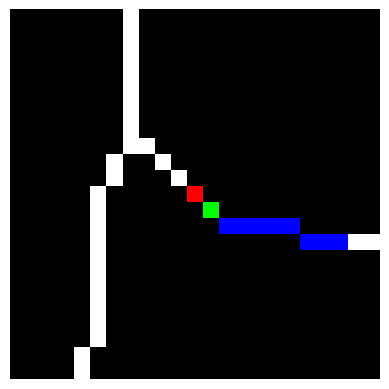

Angle is: 344.422174225689
Count threshold not reached


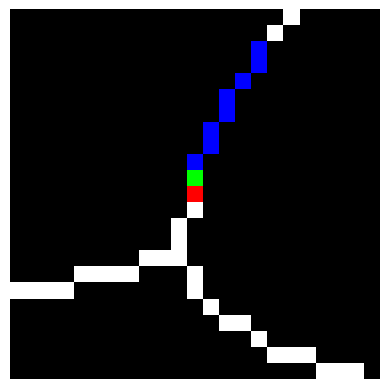

Angle is: 61.963354282738074


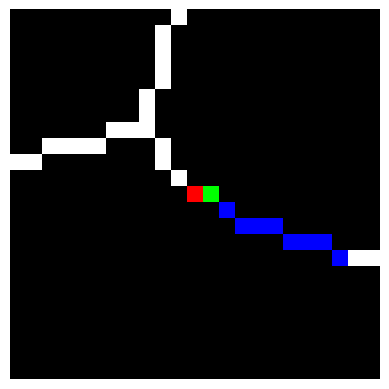

Angle is: 337.01128319791934


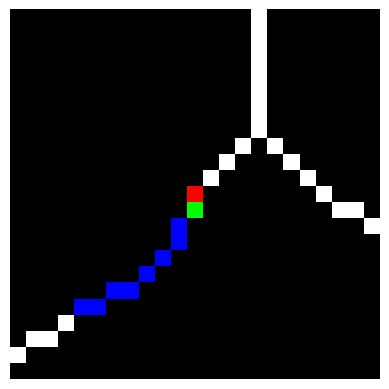

Angle is: 223.55500749402353


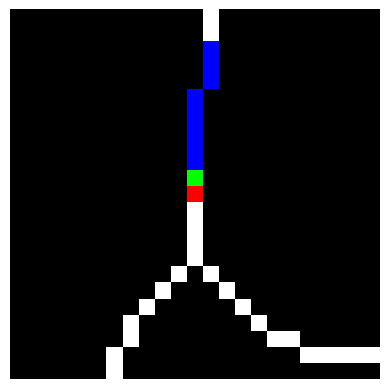

Angle is: 78.69006752597979


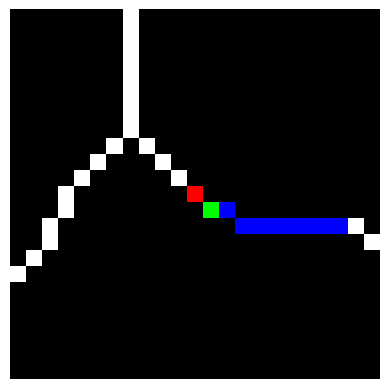

Angle is: 349.695153531234


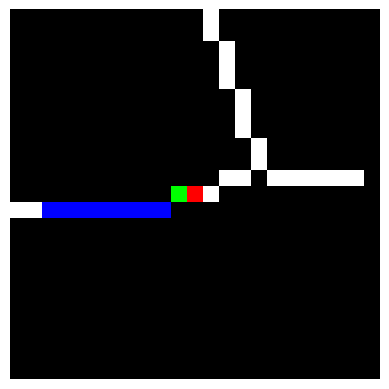

Angle is: 185.53863753279052


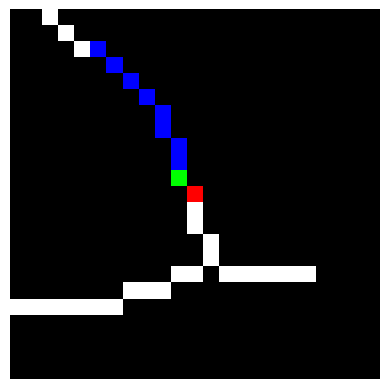

Angle is: 123.81824578980333
Count threshold not reached


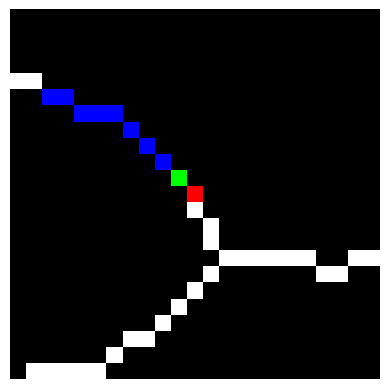

Angle is: 146.07020257793937


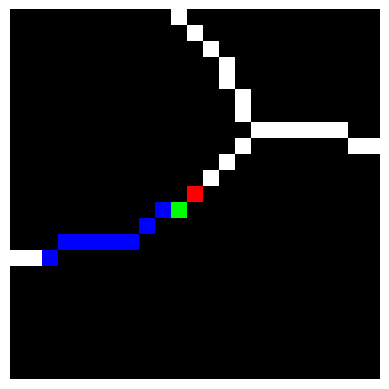

Angle is: 200.89776549883885


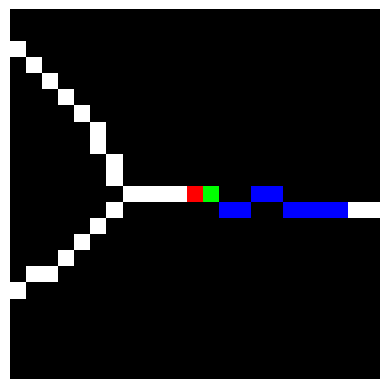

Angle is: 354.4613624672095


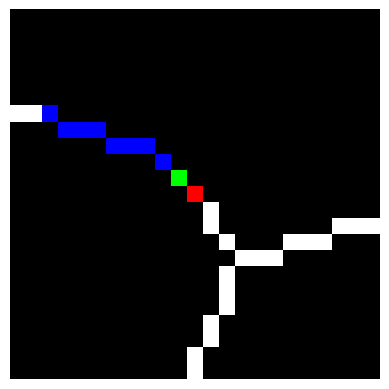

Angle is: 154.415465455963


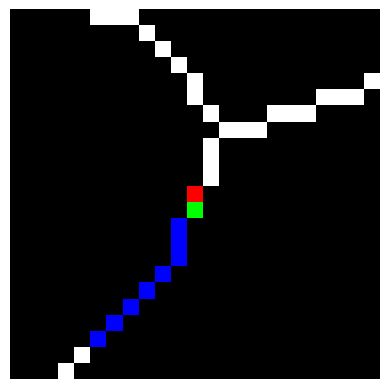

Angle is: 234.15104089980917


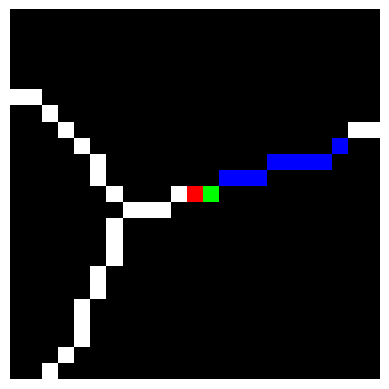

Angle is: 16.85839876773828
Descriptors for mapbox image 50.7969155-3.5948373.jpg:
[[39.28940686250036, 166.37300514010846, 253.42904883308614], [90, 258.69006752597977, 344.422174225689], [61.963354282738074, 337.01128319791934], [78.69006752597979, 223.55500749402353, 349.695153531234], [123.81824578980333, 185.53863753279052], [146.07020257793937, 200.89776549883885, 354.4613624672095], [16.85839876773828, 154.415465455963, 234.15104089980917]]
Number of descriptors: 7
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[39.28940686250036, 166.37300514010846, 253.42904883308614]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 39.28940686250036
Angle of mapbox image: 166.37300514010846
Angle of mapbox image: 253.42904883308614
Best diff = 36.19953363733059 with angle 39.28940686250036
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 39.28940686250036
Angle of mapbox image

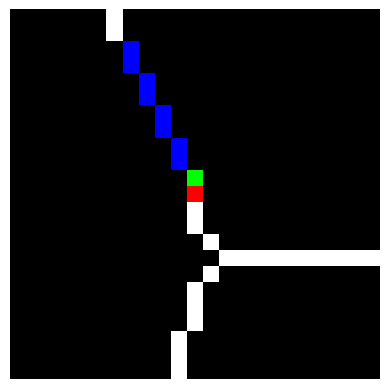

Angle is: 116.56505117707798


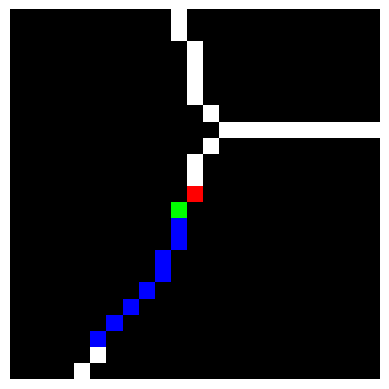

Angle is: 236.1817542101967


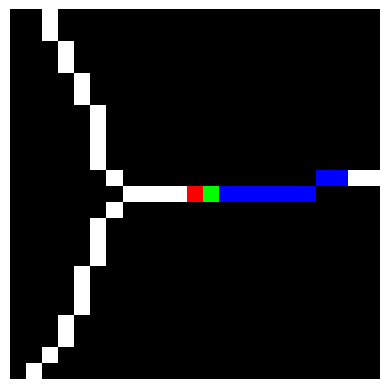

Angle is: 5.538637532790515
Descriptors for mapbox image 50.7961267-3.5930602.jpg:
[[5.538637532790515, 116.56505117707798, 236.1817542101967]]
Number of descriptors: 1
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[5.538637532790515, 116.56505117707798, 236.1817542101967]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 5.538637532790515
Angle of mapbox image: 116.56505117707798
Angle of mapbox image: 236.1817542101967
Best diff = 41.07611067724703 with angle 116.56505117707798
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 5.538637532790515
Angle of mapbox image: 116.56505117707798
Angle of mapbox image: 236.1817542101967
Best diff = 85.05915543247951 with angle 236.1817542101967
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 5.538637532790515
Angle of mapbox image: 116.56505117707798
Angle of mapbox image: 236.1817542101967
Best diff = 84.2

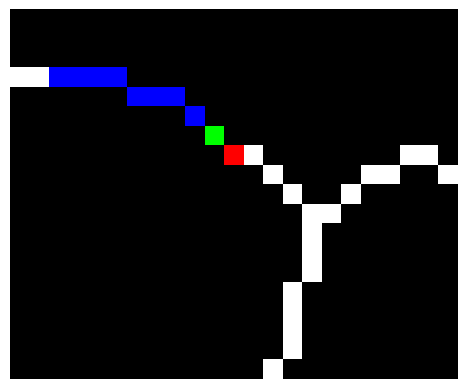

Angle is: 157.01128319791934


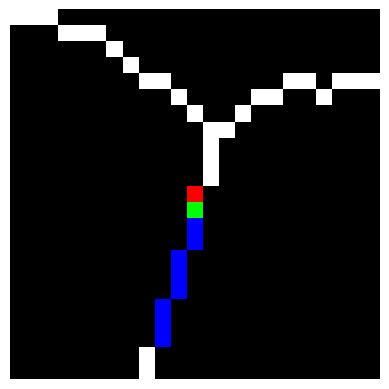

Angle is: 252.9509690278902


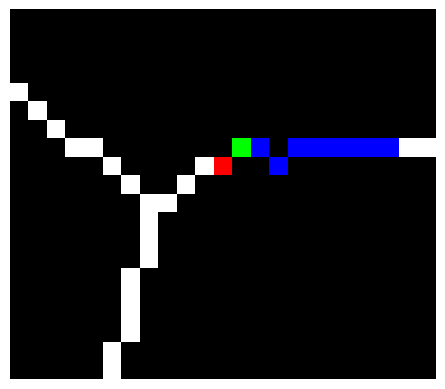

Angle is: 4.159642293712644


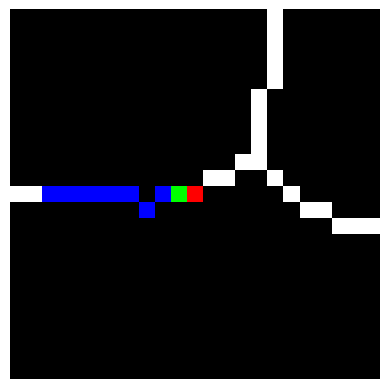

Angle is: 358.95837332399003


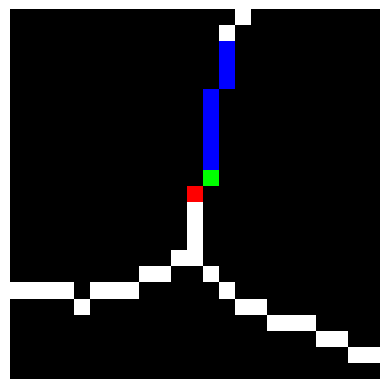

Angle is: 76.50426671920418


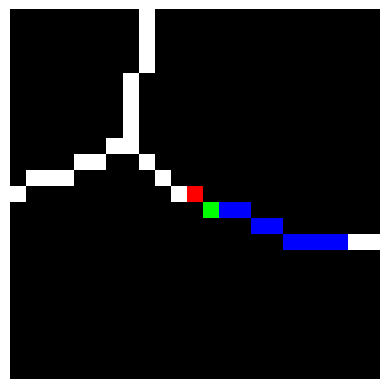

Angle is: 340.9422954898717
Descriptors for mapbox image 50.7969423-3.5925617.jpg:
[[4.159642293712644, 157.01128319791934, 252.9509690278902], [76.50426671920418, 340.9422954898717, 358.95837332399003]]
Number of descriptors: 2
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[4.159642293712644, 157.01128319791934, 252.9509690278902]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 4.159642293712644
Angle of mapbox image: 157.01128319791934
Angle of mapbox image: 252.9509690278902
Best diff = 71.3292982061183 with angle 4.159642293712644
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 4.159642293712644
Angle of mapbox image: 157.01128319791934
Angle of mapbox image: 252.9509690278902
Best diff = 5.888684420202168 with angle 157.01128319791934
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 4.159642293712644
Angle of mapbox image: 157.0112831979193

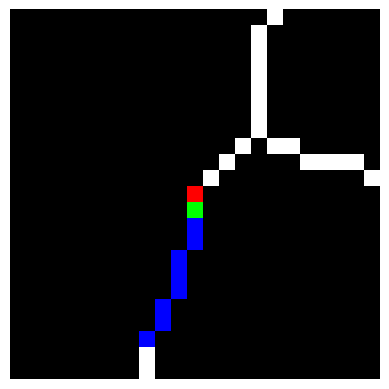

Angle is: 249.67686317033707


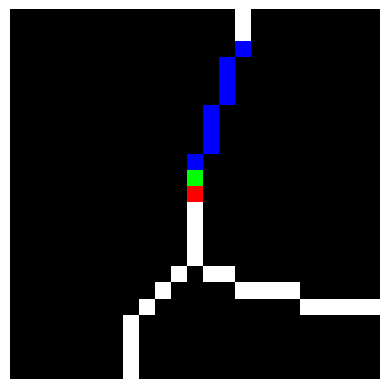

Angle is: 70.42687416958981


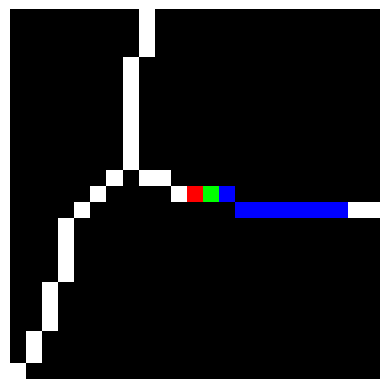

Angle is: 352.74680538727466


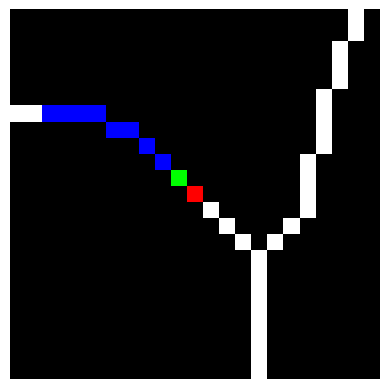

Angle is: 150.3299661843394


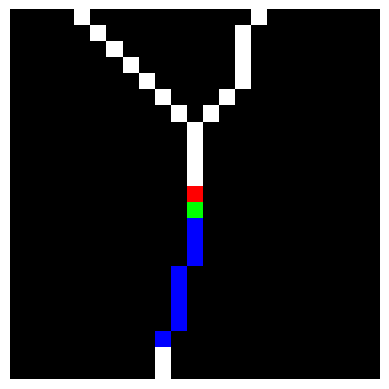

Angle is: 255.48894049983096


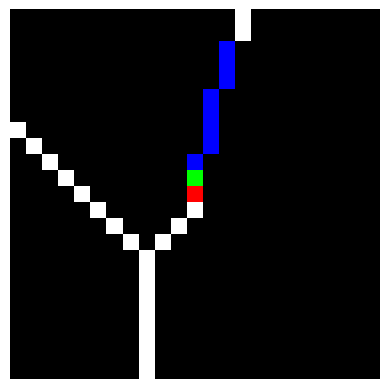

Angle is: 74.05460409907714
Descriptors for mapbox image 50.7950813-3.5911994.jpg:
[[70.42687416958981, 249.67686317033707, 352.74680538727466], [74.05460409907714, 150.3299661843394, 255.48894049983096]]
Number of descriptors: 2
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[70.42687416958981, 249.67686317033707, 352.74680538727466]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 70.42687416958981
Angle of mapbox image: 249.67686317033707
Angle of mapbox image: 352.74680538727466
Best diff = 5.062066330241137 with angle 70.42687416958981
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 70.42687416958981
Angle of mapbox image: 249.67686317033707
Angle of mapbox image: 352.74680538727466
Best diff = 98.5542643926199 with angle 249.67686317033707
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 70.42687416958981
Angle of mapbox image: 249.676863170

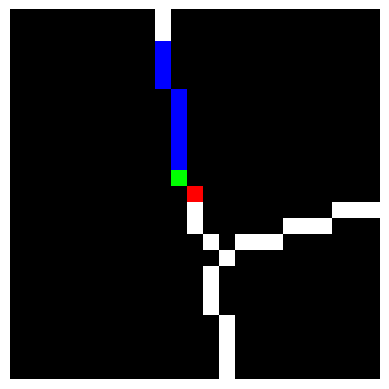

Angle is: 103.4957332807958


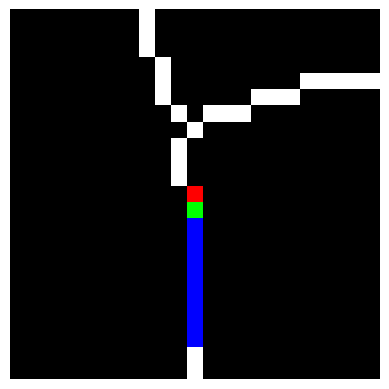

All x-values are the same
Angle is: 270


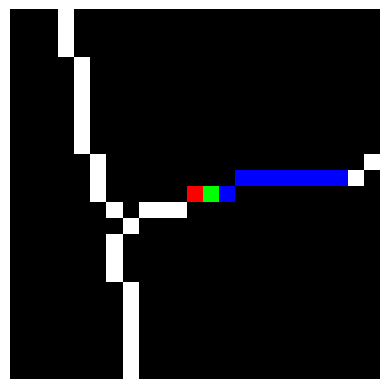

Angle is: 7.253194612725335
Descriptors for mapbox image 50.7954945-3.5886356.jpg:
[[7.253194612725335, 103.4957332807958, 270]]
Number of descriptors: 1
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[7.253194612725335, 103.4957332807958, 270]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 7.253194612725335
Angle of mapbox image: 103.4957332807958
Angle of mapbox image: 270
Best diff = 28.006792780964858 with angle 103.4957332807958
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 7.253194612725335
Angle of mapbox image: 103.4957332807958
Angle of mapbox image: 270
Best diff = 118.87740122228283 with angle 270
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 7.253194612725335
Angle of mapbox image: 103.4957332807958
Angle of mapbox image: 270
Best diff = 85.94326213870511 with angle 7.253194612725335
Result = 149.34008594574232
Score = 12.220478

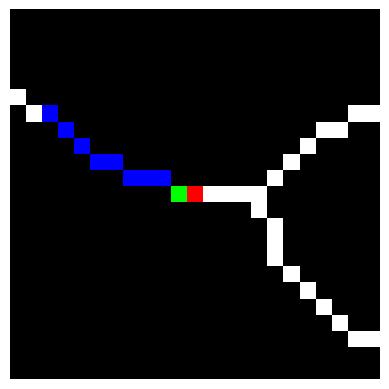

Angle is: 152.19854122006586


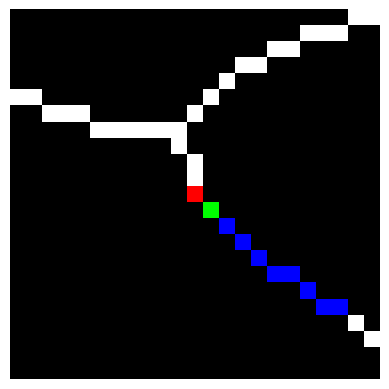

Angle is: 321.3401917459099


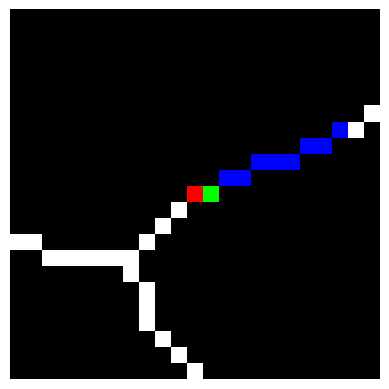

Angle is: 22.988716802080642


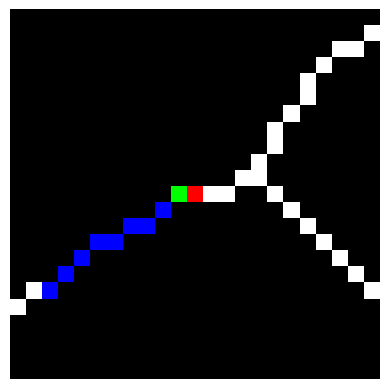

Angle is: 213.20657031508952


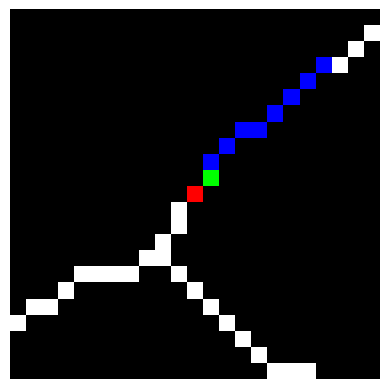

Angle is: 42.77222573496257


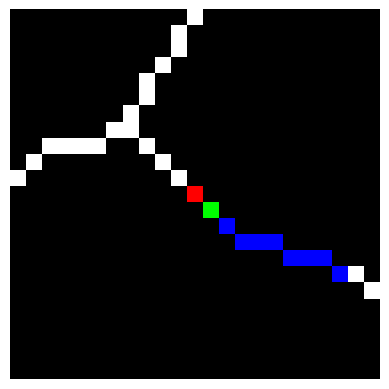

Angle is: 334.415465455963
Descriptors for mapbox image 50.7963052-3.5876732.jpg:
[[22.988716802080642, 152.19854122006586, 321.3401917459099], [42.77222573496257, 213.20657031508952, 334.415465455963]]
Number of descriptors: 2
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[22.988716802080642, 152.19854122006586, 321.3401917459099]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 22.988716802080642
Angle of mapbox image: 152.19854122006586
Angle of mapbox image: 321.3401917459099
Best diff = 52.5002236977503 with angle 22.988716802080642
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 22.988716802080642
Angle of mapbox image: 152.19854122006586
Angle of mapbox image: 321.3401917459099
Best diff = 1.0759424423486905 with angle 152.19854122006586
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 22.988716802080642
Angle of mapbox image: 152.19854122

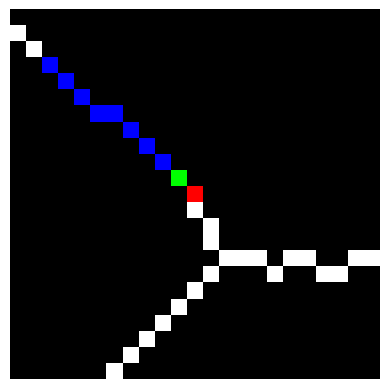

Angle is: 139.48460600954462
Count threshold not reached


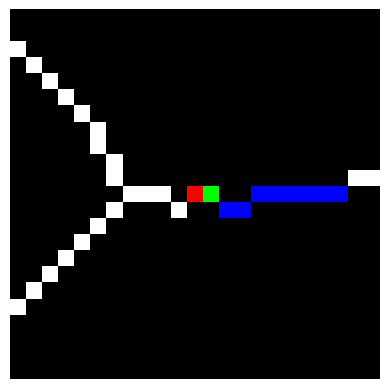

Angle is: 182.77580344878314


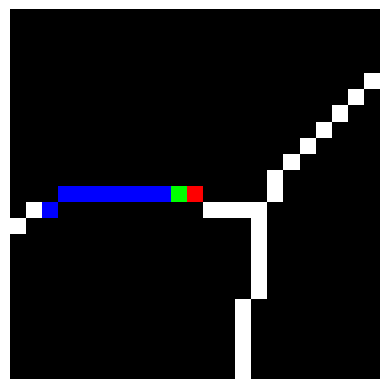

Angle is: 183.1221304621157


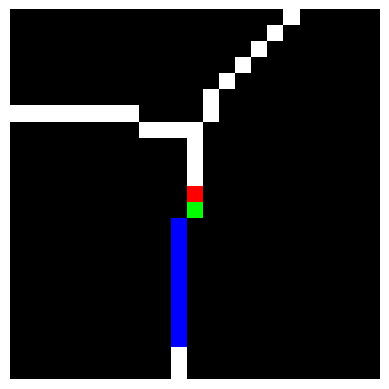

Angle is: 258.69006752597977
Count threshold not reached


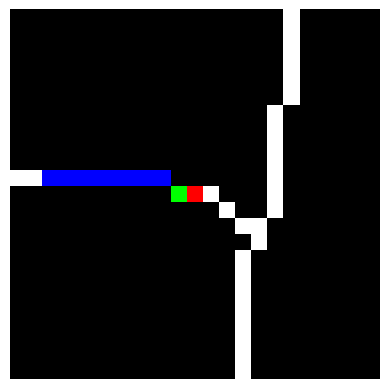

Angle is: 174.46136246720948


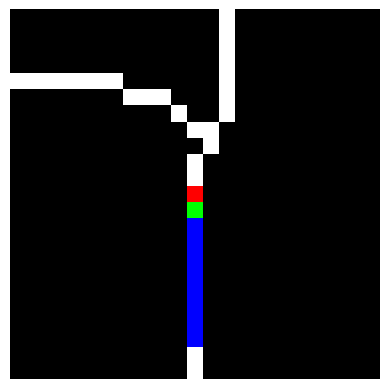

All x-values are the same
Angle is: 270


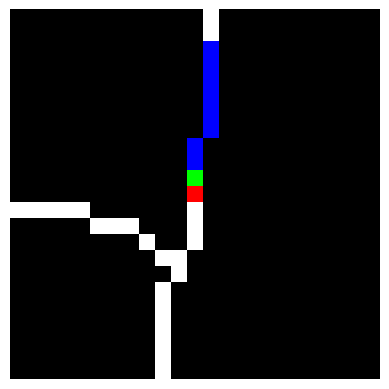

Angle is: 78.69006752597979
Descriptors for mapbox image 50.7942715-3.59287.jpg:
[[139.48460600954462, 182.77580344878314, 183.1221304621157, 258.69006752597977], [78.69006752597979, 174.46136246720948, 270]]
Number of descriptors: 2
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[139.48460600954462, 182.77580344878314, 183.1221304621157, 258.69006752597977]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 139.48460600954462
Angle of mapbox image: 182.77580344878314
Angle of mapbox image: 183.1221304621157
Angle of mapbox image: 258.69006752597977
Best diff = 63.995665509713675 with angle 139.48460600954462
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 139.48460600954462
Angle of mapbox image: 182.77580344878314
Angle of mapbox image: 183.1221304621157
Angle of mapbox image: 258.69006752597977
Best diff = 31.653204671065964 with angle 182.77580344878314
Angle of segm

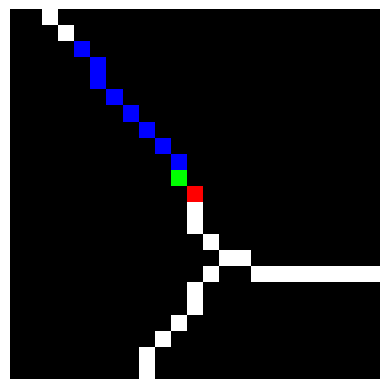

Angle is: 129.33629374197943


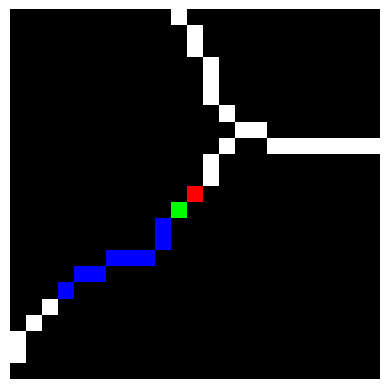

Angle is: 213.93881753840822


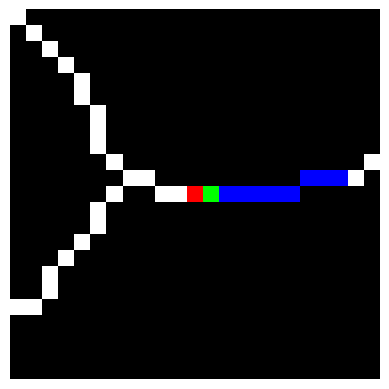

Angle is: 7.253194612725332


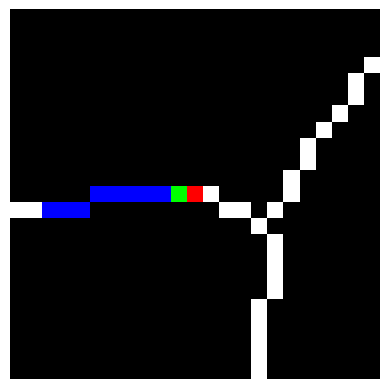

Angle is: 187.25319461272534


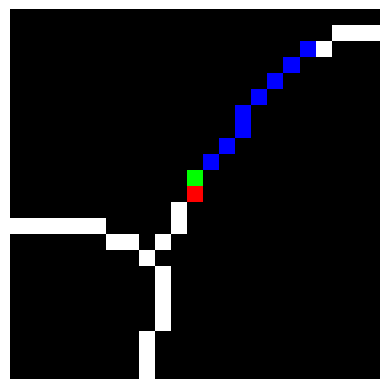

Angle is: 51.07449257691838


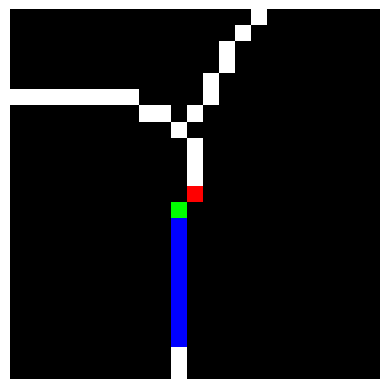

Angle is: 258.69006752597977
Descriptors for mapbox image 50.7935559-3.5936877.jpg:
[[7.253194612725332, 129.33629374197943, 213.93881753840822], [51.07449257691838, 187.25319461272534, 258.69006752597977]]
Number of descriptors: 2
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[7.253194612725332, 129.33629374197943, 213.93881753840822]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 7.253194612725332
Angle of mapbox image: 129.33629374197943
Angle of mapbox image: 213.93881753840822
Best diff = 53.847353242148486 with angle 129.33629374197943
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 7.253194612725332
Angle of mapbox image: 129.33629374197943
Angle of mapbox image: 213.93881753840822
Best diff = 62.816218760691044 with angle 213.93881753840822
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 7.253194612725332
Angle of mapbox image: 129.336

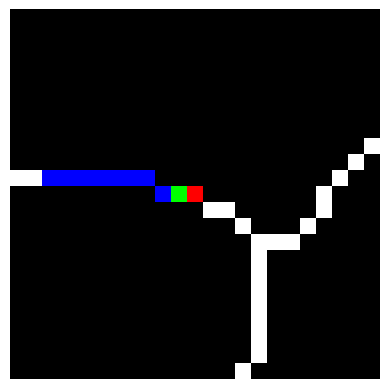

Angle is: 172.74680538727466


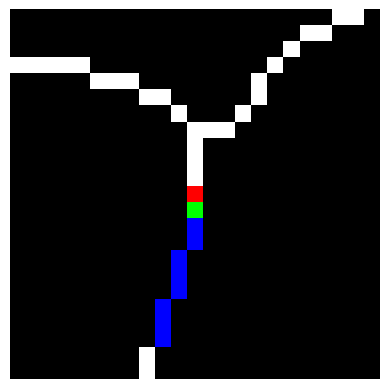

Angle is: 252.9509690278902


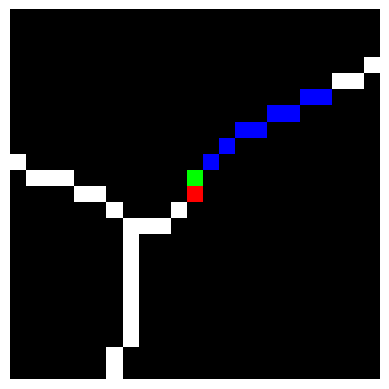

Angle is: 34.639051932630515


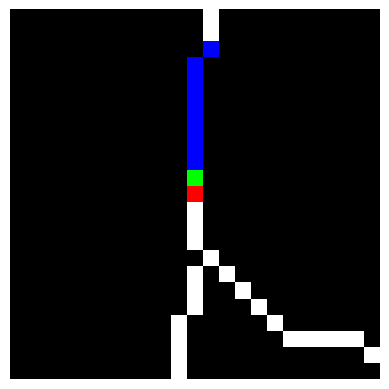

Angle is: 78.69006752597979


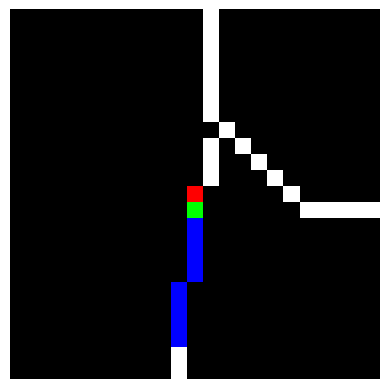

Angle is: 258.69006752597977


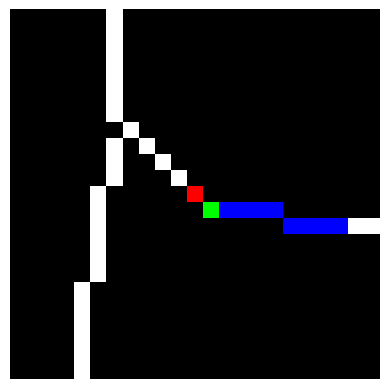

Angle is: 348.69006752597977


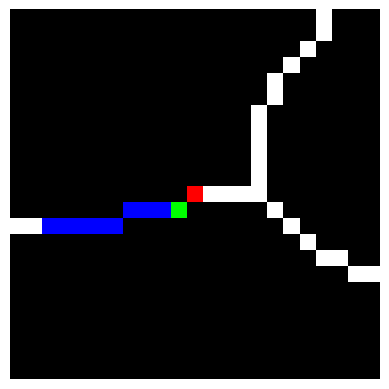

Angle is: 191.6434314987617


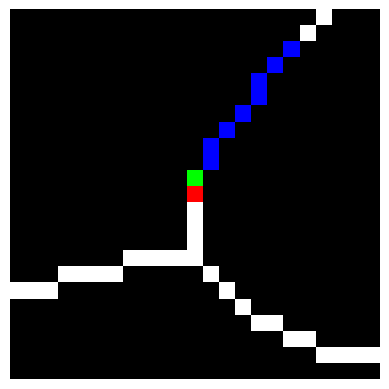

Angle is: 54.672056237838675


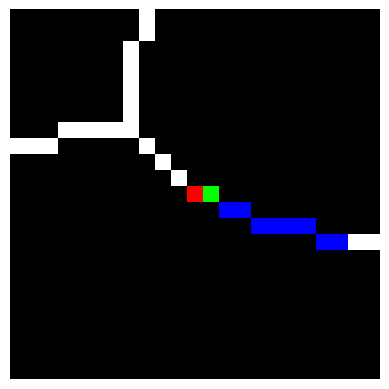

Angle is: 341.2530990172167


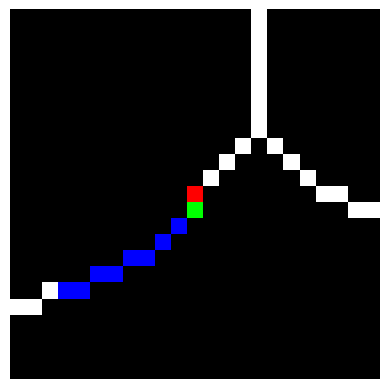

Angle is: 214.63905193263048


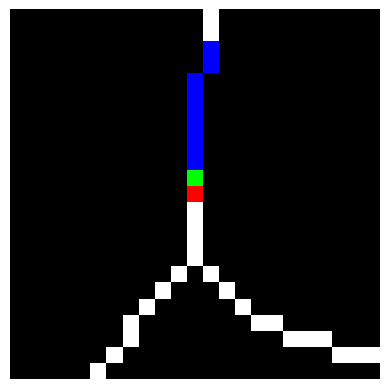

Angle is: 78.69006752597979


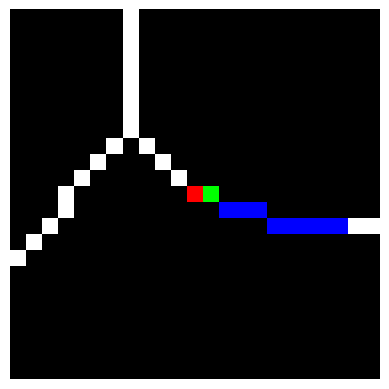

Angle is: 346.04549082686316


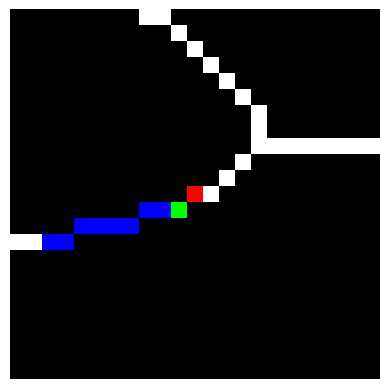

Angle is: 196.53982400122894


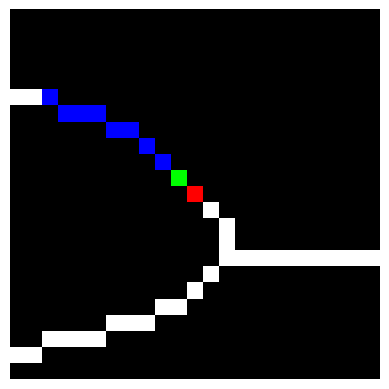

Angle is: 148.0258406468708


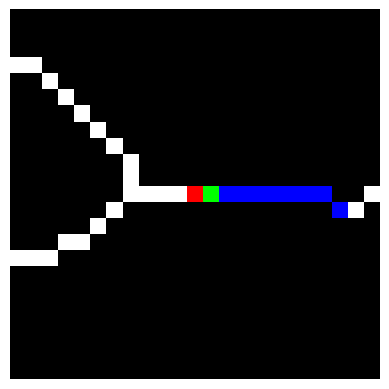

Angle is: 356.8778695378843


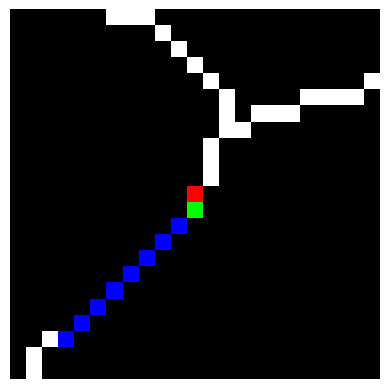

Angle is: 226.35319195377969


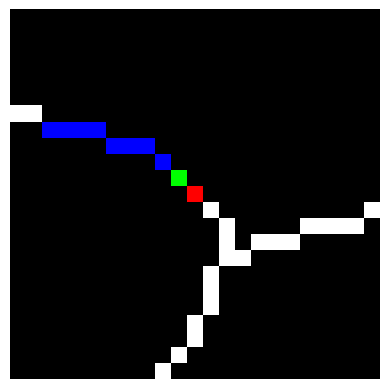

Angle is: 157.01128319791934


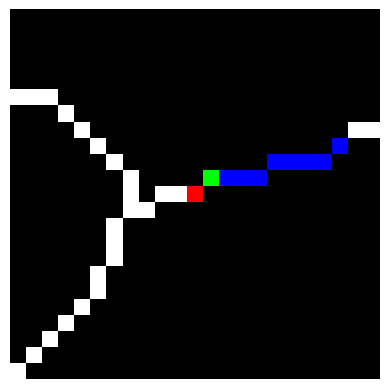

Angle is: 14.606737354446999
Descriptors for mapbox image 50.7968232-3.5941811.jpg:
[[34.639051932630515, 172.74680538727466, 252.9509690278902], [78.69006752597979, 258.69006752597977, 348.69006752597977], [54.672056237838675, 191.6434314987617, 341.2530990172167], [78.69006752597979, 214.63905193263048, 346.04549082686316], [148.0258406468708, 196.53982400122894, 356.8778695378843], [14.606737354446999, 157.01128319791934, 226.35319195377969]]
Number of descriptors: 6
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[34.639051932630515, 172.74680538727466, 252.9509690278902]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 34.639051932630515
Angle of mapbox image: 172.74680538727466
Angle of mapbox image: 252.9509690278902
Best diff = 40.84988856720043 with angle 34.639051932630515
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 34.639051932630515
Angle of mapbox image

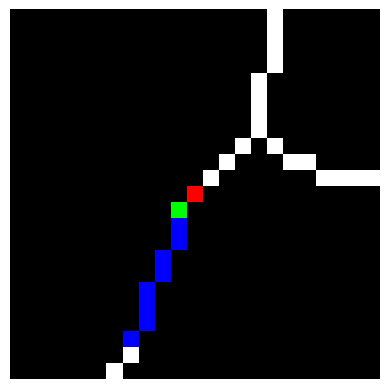

Angle is: 247.01128319791937


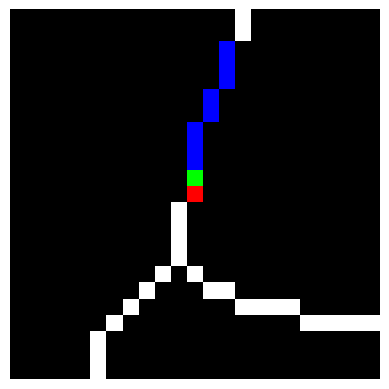

Angle is: 71.7146481726805


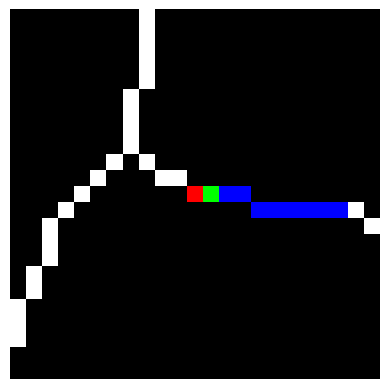

Angle is: 351.7241071729248


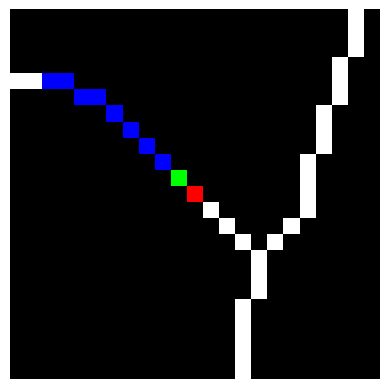

Angle is: 140.71059313749964


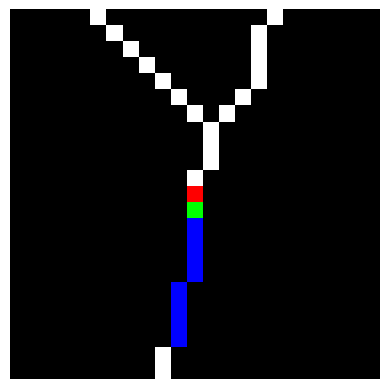

Angle is: 258.69006752597977


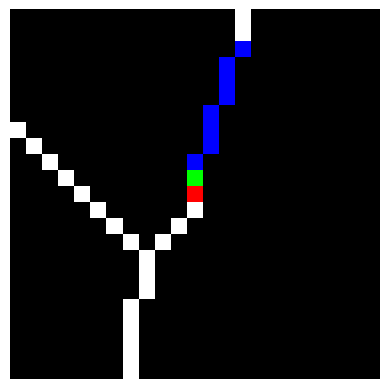

Angle is: 70.42687416958981
Descriptors for mapbox image 50.7947894-3.5913995.jpg:
[[71.7146481726805, 247.01128319791937, 351.7241071729248], [70.42687416958981, 140.71059313749964, 258.69006752597977]]
Number of descriptors: 2
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[71.7146481726805, 247.01128319791937, 351.7241071729248]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 71.7146481726805
Angle of mapbox image: 247.01128319791937
Angle of mapbox image: 351.7241071729248
Best diff = 3.774292327150448 with angle 71.7146481726805
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 71.7146481726805
Angle of mapbox image: 247.01128319791937
Angle of mapbox image: 351.7241071729248
Best diff = 95.8886844202022 with angle 247.01128319791937
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 71.7146481726805
Angle of mapbox image: 247.01128319791937
Ang

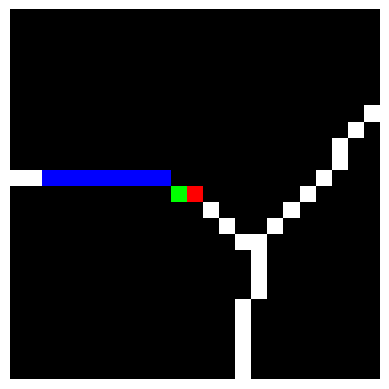

Angle is: 174.46136246720948


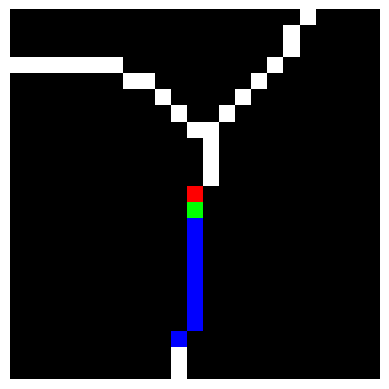

Angle is: 258.69006752597977


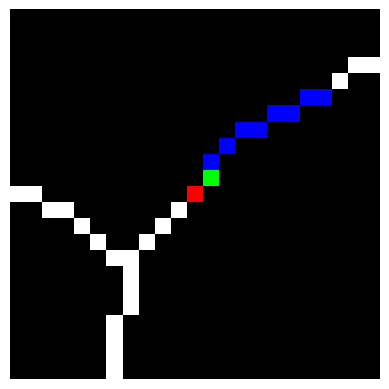

Angle is: 35.6251279217423


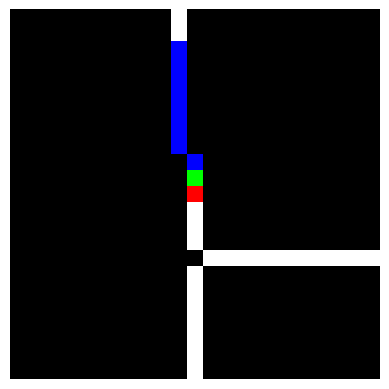

Angle is: 101.30993247402021


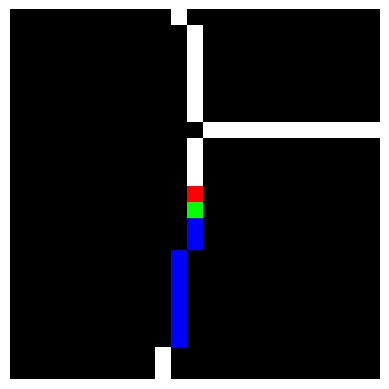

Angle is: 258.69006752597977


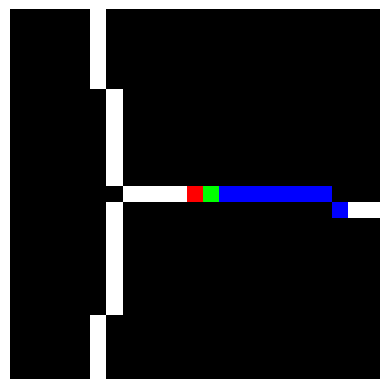

Angle is: 356.8778695378843


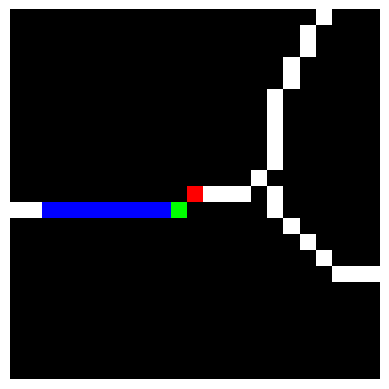

Angle is: 183.1221304621157


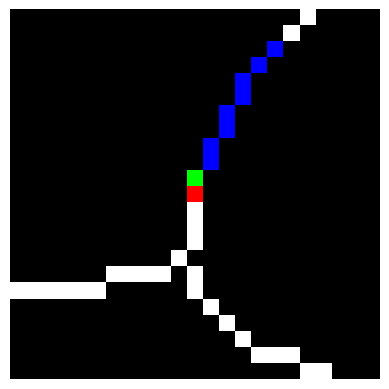

Angle is: 60.77078073253677


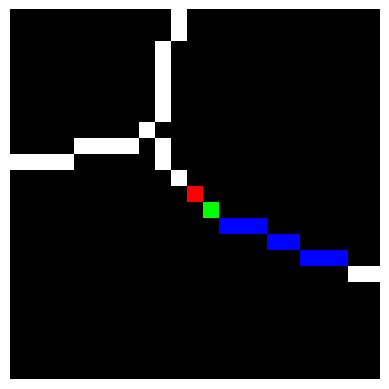

Angle is: 336.7176437865103


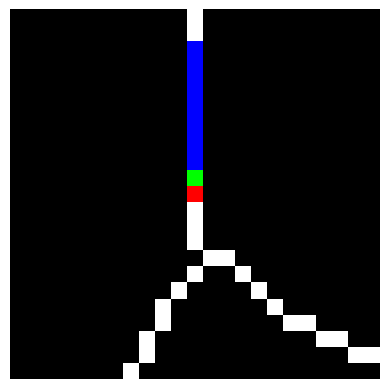

All x-values are the same
Angle is: 90


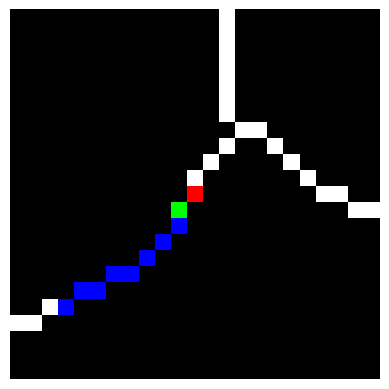

Angle is: 219.28024247046187


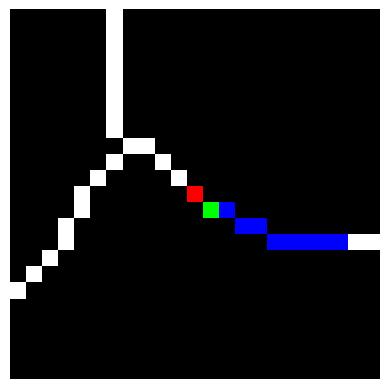

Angle is: 341.565051177078


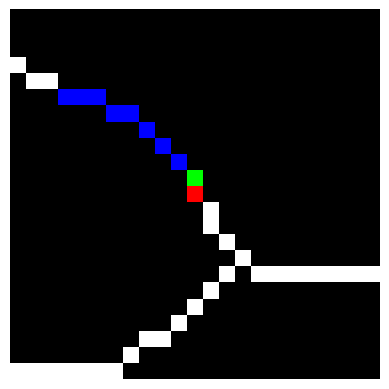

Angle is: 143.9268632224611


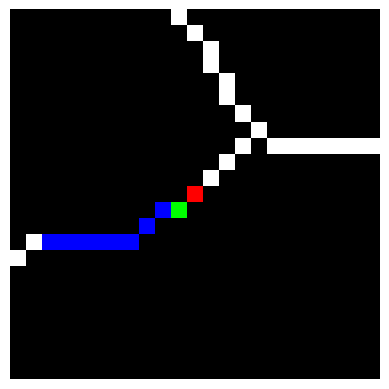

Angle is: 198.12186024790134


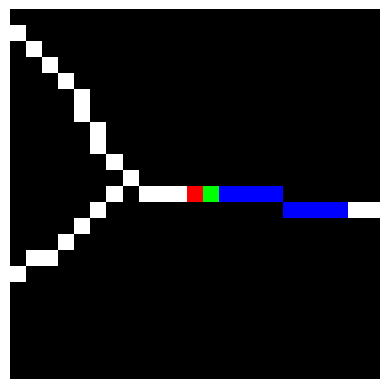

Angle is: 351.7241071729248


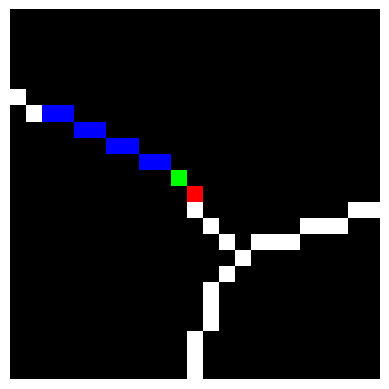

Angle is: 151.65784555657865


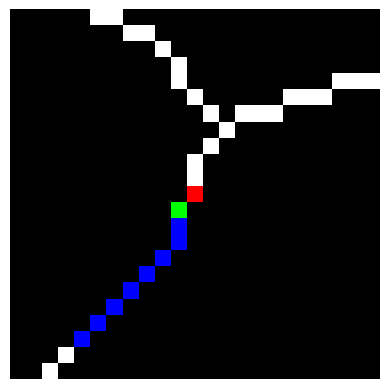

Angle is: 230.9061411137705


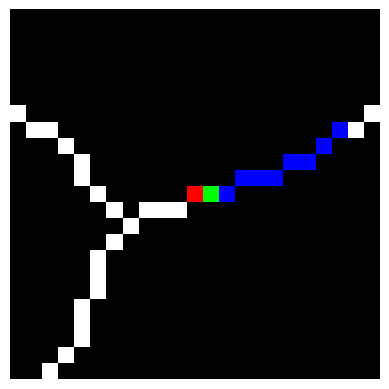

Angle is: 22.98871680208064
Descriptors for mapbox image 50.7970808-3.5946203.jpg:
[[35.6251279217423, 174.46136246720948, 258.69006752597977], [101.30993247402021, 258.69006752597977, 356.8778695378843], [60.77078073253677, 183.1221304621157, 336.7176437865103], [90, 219.28024247046187, 341.565051177078], [143.9268632224611, 198.12186024790134, 351.7241071729248], [22.98871680208064, 151.65784555657865, 230.9061411137705]]
Number of descriptors: 6
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[35.6251279217423, 174.46136246720948, 258.69006752597977]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 35.6251279217423
Angle of mapbox image: 174.46136246720948
Angle of mapbox image: 258.69006752597977
Best diff = 39.86381257808865 with angle 35.6251279217423
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 35.6251279217423
Angle of mapbox image: 174.46136246720948
Angle o

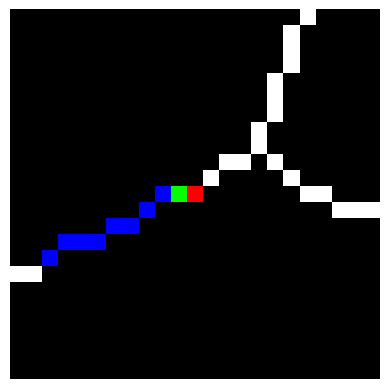

Angle is: 205.30137862541972


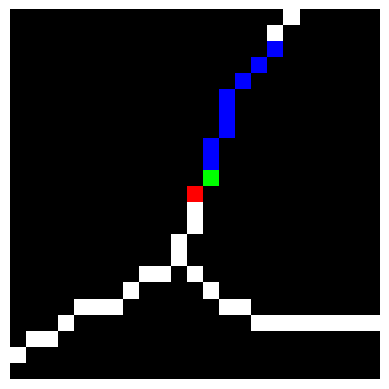

Angle is: 62.1160597690708


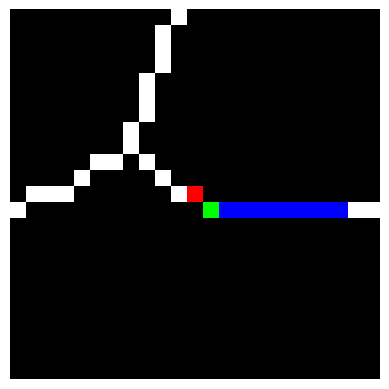

Angle is: 356.8778695378843
Descriptors for mapbox image 50.7948203-3.5940027.jpg:
[[62.1160597690708, 205.30137862541972, 356.8778695378843]]
Number of descriptors: 1
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[62.1160597690708, 205.30137862541972, 356.8778695378843]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 62.1160597690708
Angle of mapbox image: 205.30137862541972
Angle of mapbox image: 356.8778695378843
Best diff = 13.372880730760144 with angle 62.1160597690708
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 62.1160597690708
Angle of mapbox image: 205.30137862541972
Angle of mapbox image: 356.8778695378843
Best diff = 54.17877984770254 with angle 205.30137862541972
Angle of segmentation image: 281.30993247402023
Angle of mapbox image: 62.1160597690708
Angle of mapbox image: 205.30137862541972
Angle of mapbox image: 356.8778695378843
Best diff = 75.567937

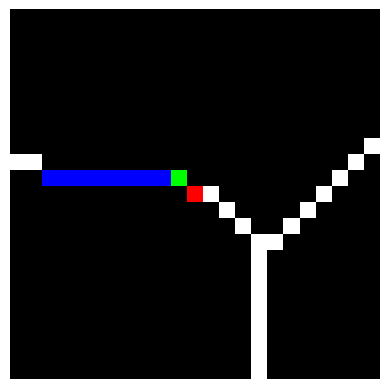

Angle is: 176.8778695378843


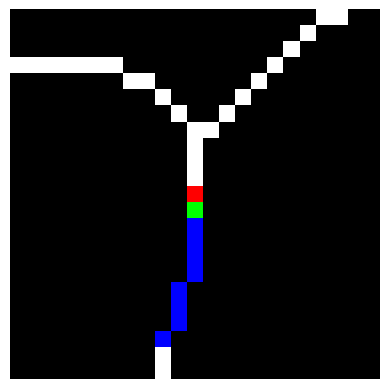

Angle is: 254.74488129694222


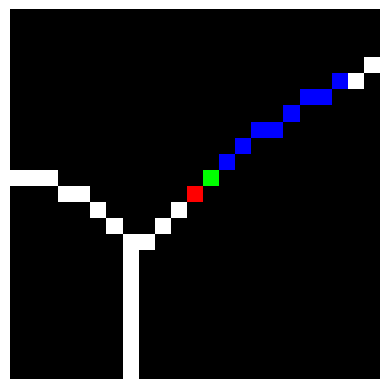

Angle is: 36.92541679466238


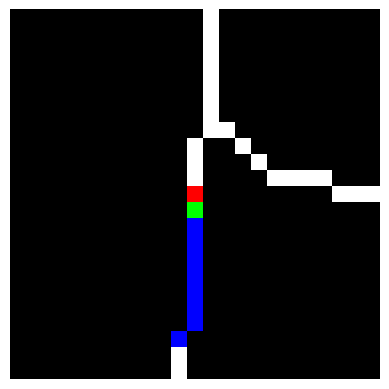

Angle is: 258.69006752597977


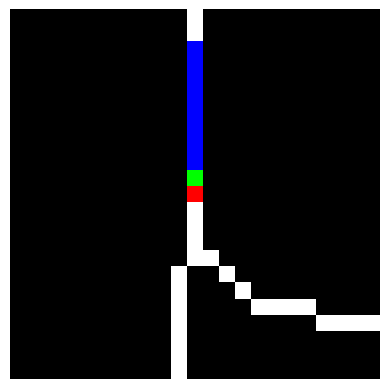

All x-values are the same
Angle is: 90


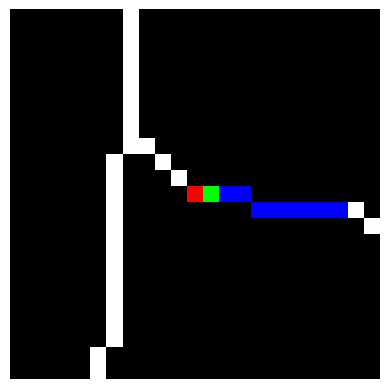

Angle is: 351.7241071729248


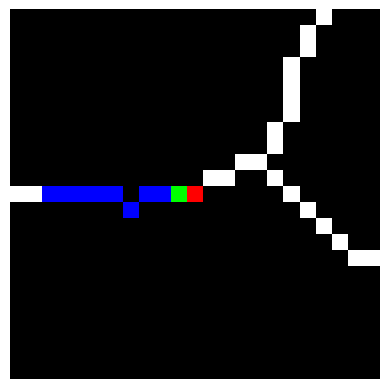

Angle is: 359.6527571029142


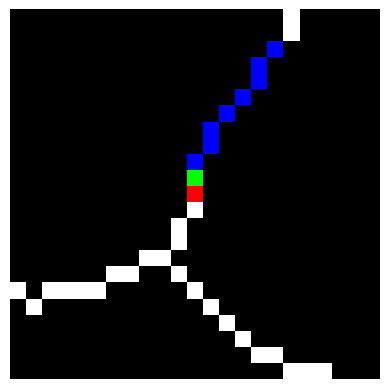

Angle is: 57.38075692880717


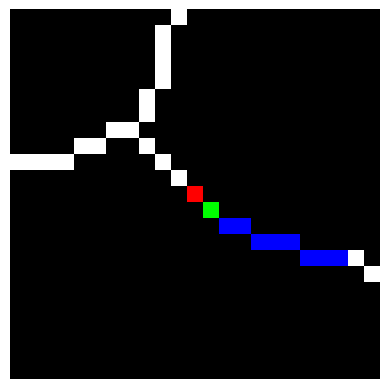

Angle is: 337.01128319791934


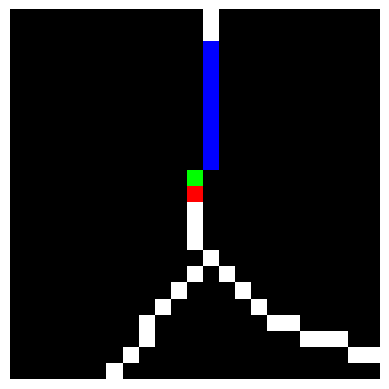

Angle is: 78.69006752597979


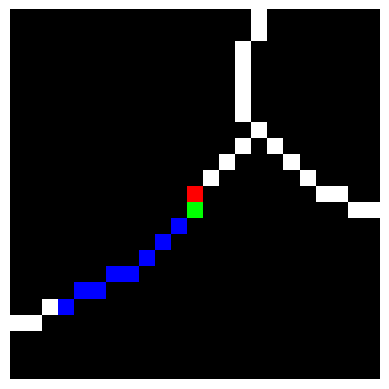

Angle is: 218.22518501773868


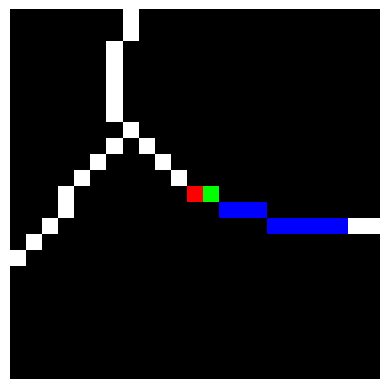

Angle is: 346.04549082686316


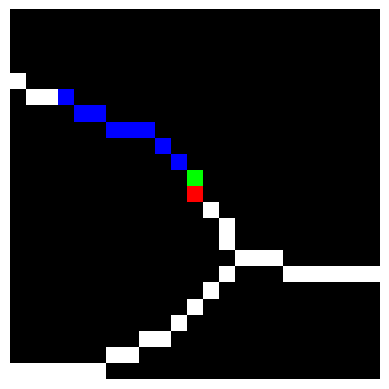

Angle is: 147.93927193638118


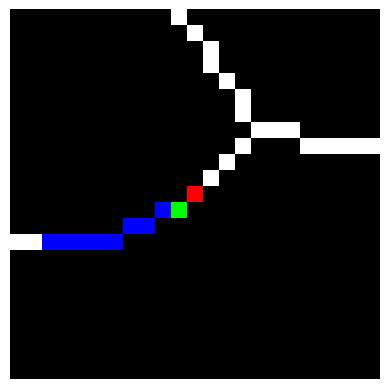

Angle is: 198.43494882292202


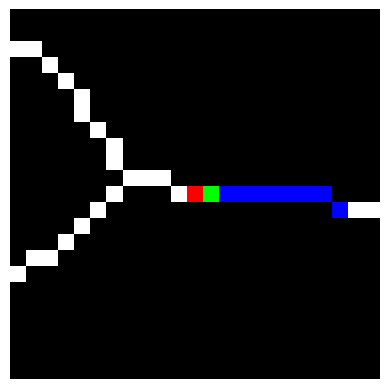

Angle is: 356.8778695378843


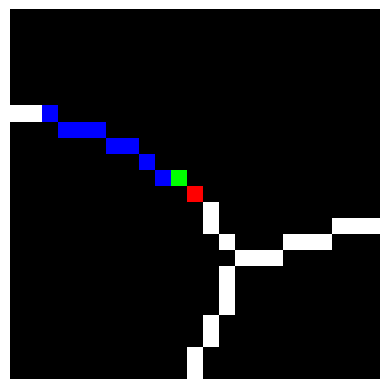

Angle is: 152.19854122006586


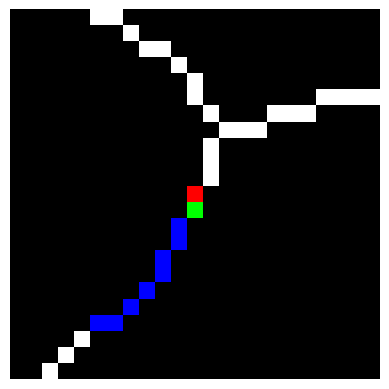

Angle is: 233.23726391158277


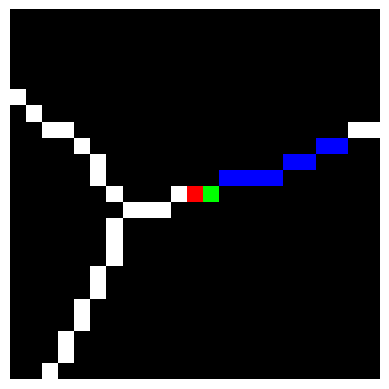

Angle is: 18.746900982783288
Descriptors for mapbox image 50.7969549-3.5946137.jpg:
[[36.92541679466238, 176.8778695378843, 254.74488129694222], [90, 258.69006752597977, 351.7241071729248], [57.38075692880717, 337.01128319791934, 359.6527571029142], [78.69006752597979, 218.22518501773868, 346.04549082686316], [147.93927193638118, 198.43494882292202, 356.8778695378843], [18.746900982783288, 152.19854122006586, 233.23726391158277]]
Number of descriptors: 6
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[36.92541679466238, 176.8778695378843, 254.74488129694222]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 36.92541679466238
Angle of mapbox image: 176.8778695378843
Angle of mapbox image: 254.74488129694222
Best diff = 38.56352370516856 with angle 36.92541679466238
Angle of segmentation image: 151.12259877771717
Angle of mapbox image: 36.92541679466238
Angle of mapbox image: 176.8778695378843


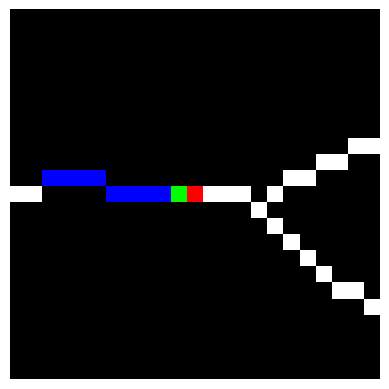

Angle is: 171.7241071729248


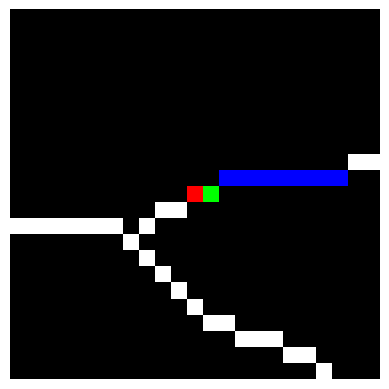

Angle is: 5.538637532790519


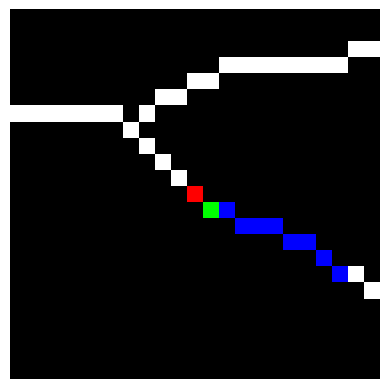

Angle is: 334.415465455963


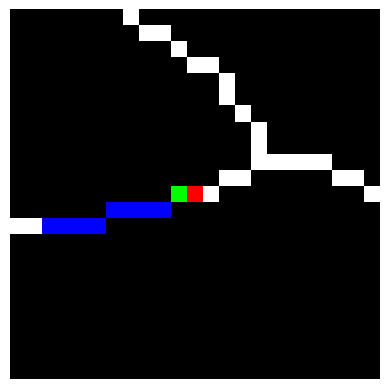

Angle is: 193.62699485989154


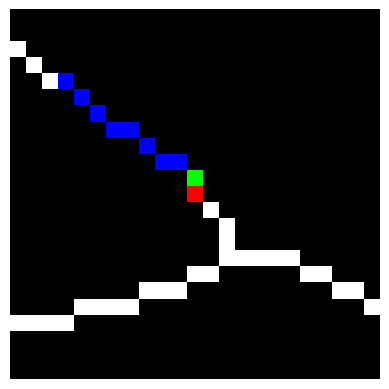

Angle is: 142.73783956028123


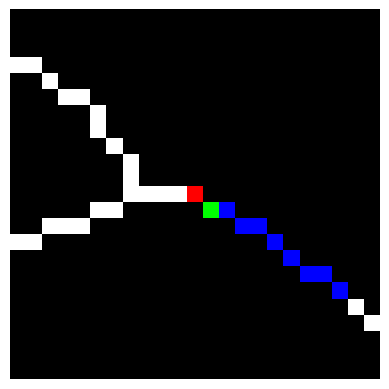

Angle is: 326.5510072625253


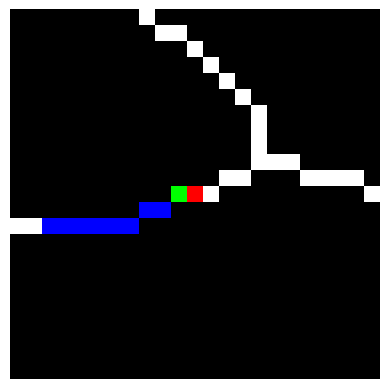

Angle is: 193.62699485989154


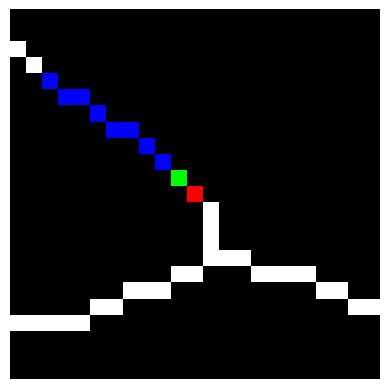

Angle is: 143.0745832053376


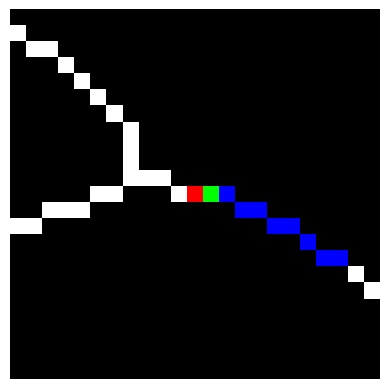

Angle is: 333.2962183930344


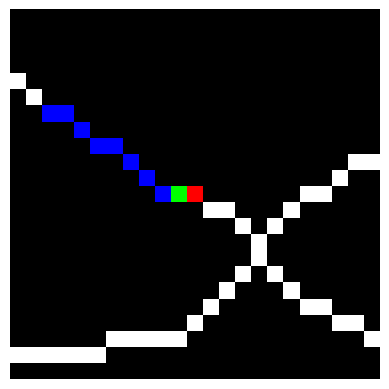

Angle is: 147.03720232036574


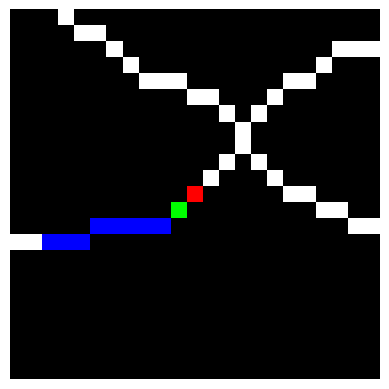

Angle is: 195.57782577431104


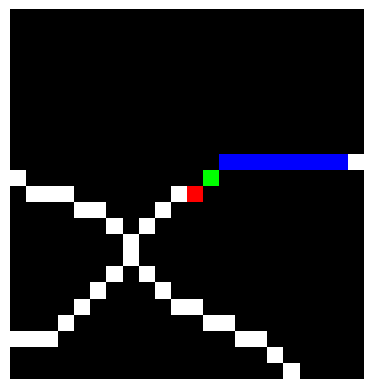

Angle is: 8.615648184164117


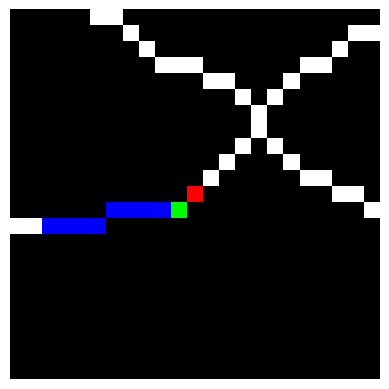

Angle is: 191.30993247402023


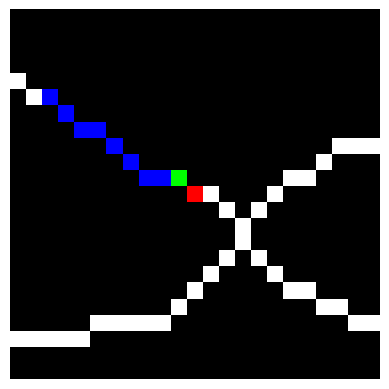

Angle is: 147.03720232036574


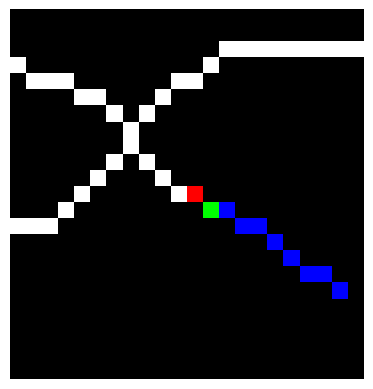

Angle is: 326.5510072625253


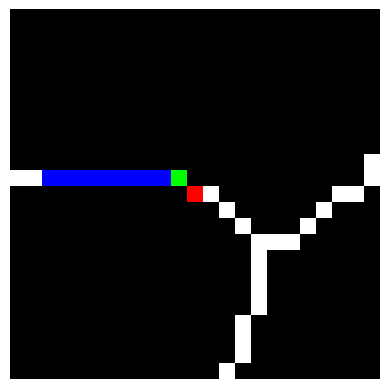

Angle is: 176.8778695378843


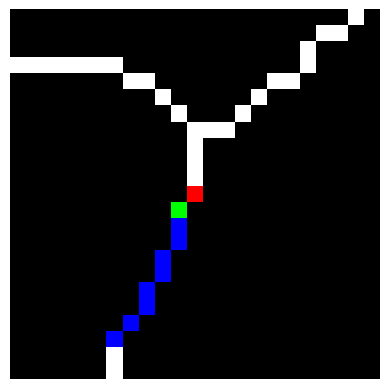

Angle is: 242.21842592097957


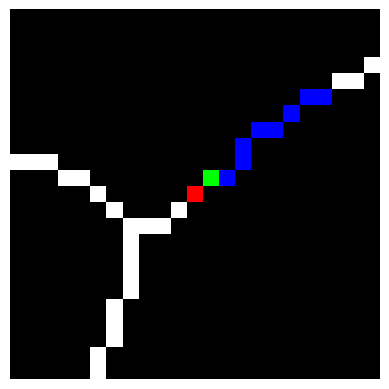

Angle is: 38.93411270300349


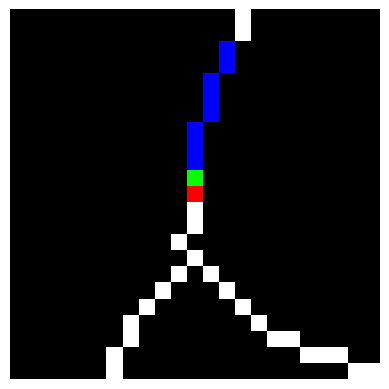

Angle is: 73.42904883308616


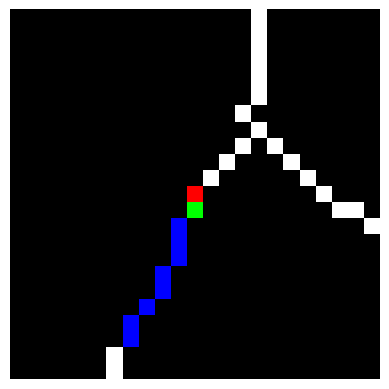

Angle is: 243.31753960301296


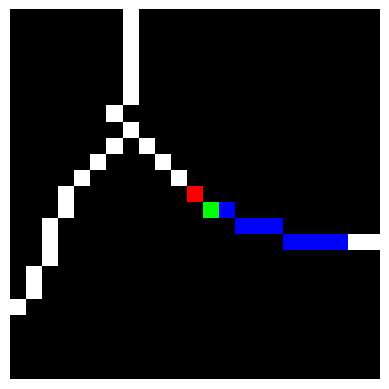

Angle is: 341.87813975209866


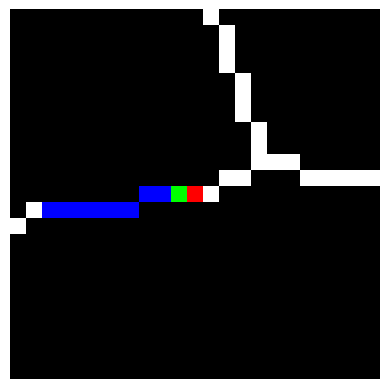

Angle is: 188.2758928270752


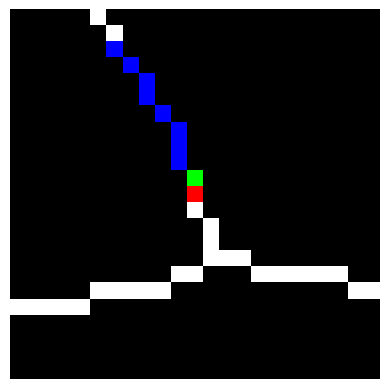

Angle is: 120.01836742760909


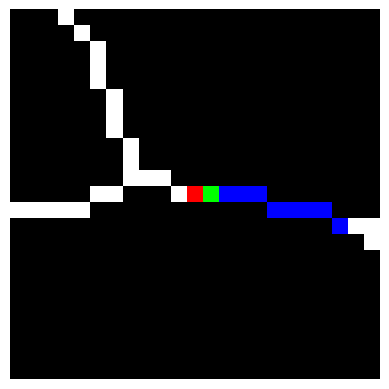

Angle is: 348.3565685012383


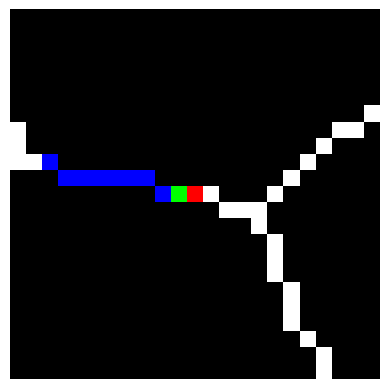

Angle is: 169.69515353123396


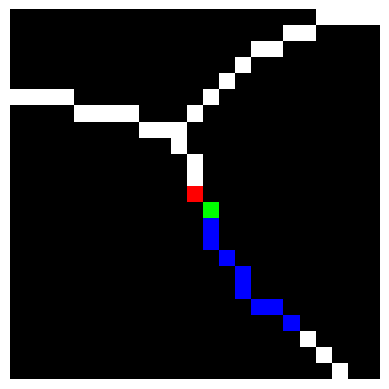

Angle is: 306.6709547664834


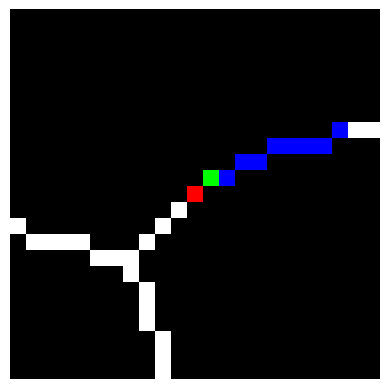

Angle is: 21.200216655641025
Descriptors for mapbox image 50.7965324-3.5951496.jpg:
[[5.538637532790519, 171.7241071729248, 334.415465455963], [142.73783956028123, 193.62699485989154, 326.5510072625253], [143.0745832053376, 193.62699485989154, 333.2962183930344], [8.615648184164117, 147.03720232036574, 195.57782577431104], [147.03720232036574, 191.30993247402023, 326.5510072625253], [38.93411270300349, 176.8778695378843, 242.21842592097957], [73.42904883308616, 243.31753960301296, 341.87813975209866], [120.01836742760909, 188.2758928270752, 348.3565685012383], [21.200216655641025, 169.69515353123396, 306.6709547664834]]
Number of descriptors: 9
Descriptor of segmentation image:
[75.48894049983095, 151.12259877771717, 281.30993247402023]
Descriptor of mapbox image:
[5.538637532790519, 171.7241071729248, 334.415465455963]
Angle of segmentation image: 75.48894049983095
Angle of mapbox image: 5.538637532790519
Angle of mapbox image: 171.7241071729248
Angle of mapbox image: 334.415465455963

In [58]:
best_mb_image = None
scores = dict()
visualize = False 

for mb_image in os.listdir(mapbox_imgs_dir_path) : 
    best_results = []
    mb_image_path = os.path.join(mapbox_imgs_dir_path, mb_image)
    print(50*"*")
    print(f"Mapbox image: {mb_image}")
    print(50*"*")
    mb_image_bgr = cv2.imread(mb_image_path)
    if visualize : 
        plot_image(mb_image_bgr)
    des = find_descriptors_in_mapbox_image(mb_image_path, mb_image, vis=visualize)
    print(f"Descriptors for mapbox image {mb_image}:")
    print(des)

    # matching process
    if des is not None and segm_img_des is not None :
        print(f"Number of descriptors: {len(des)}")
        for des_segm in segm_img_des :
            best_result_per_des = 1000 # best descriptor match for descriptor des_segm of segmentation image
            print(f"Descriptor of segmentation image:")
            print(des_segm)
            for des_mb in des :
                print(f"Descriptor of mapbox image:")
                print(des_mb)

                if len(des_mb) < len(des_segm) : 
                    continue

                result = 0
                processed_angles = []
                for angle_des_segm in des_segm :
                    print(f"Angle of segmentation image: {angle_des_segm}") 
                    best_diff = 1000
                    for angle_des_mb in des_mb :
                        print(f"Angle of mapbox image: {angle_des_mb}")
                        if angle_des_mb in processed_angles : 
                            continue
                        diff = min(abs(angle_des_segm-angle_des_mb), abs((angle_des_segm+360)-angle_des_mb), abs((angle_des_mb+360)-angle_des_segm))
                        if diff < best_diff :
                            best_diff = diff
                            best_angle_des_mb = angle_des_mb
                    
                    print(f"Best diff = {best_diff} with angle {best_angle_des_mb}")
                    processed_angles.append(best_angle_des_mb)
                    result += best_diff**2
                
                
                result = math.sqrt(result)
                print(f"Result = {result}")
            
                if result < best_result_per_des :
                    best_result_per_des = result

            best_results.append(best_result_per_des)
        
        score =  math.sqrt(np.sum(best_results))
        print(f"Score = {score}")
        
        # make sure there is at least one best result that is below the threshold 
        threshold = 40

        # If at least one result is below the threshold, add the score to the dictionary
        # if any(result < threshold for result in best_results) :
        #   print(f"At least one result is below the threshold, add the score to the dictionary for mapbox image {mb_image}")
        #   scores[mb_image] = score
        scores[mb_image] = score
    else:
        continue


# Get the lowest three values using sorted() and dictionary items()
lowest_values = sorted(scores.values())[:3]
print(50*"*")
print("Top 3 results:")
print(50*"*")
for value in lowest_values:
    # For each value, get the corresponding key
    for key in scores.keys():
        if scores[key] == value:
            print(f"Score = {value} with mapbox image {key}")